In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
import torchvision

def get_version(package):
    try:
        return package.__version__
    except AttributeError:
        return "Version information not available"

# List of packages to check
packages = {
    "numpy": np,
    "pandas": pd,
    "matplotlib": plt,
    "seaborn": sns,
    "PIL": Image,
    "torch": torch,
    "torchvision": torchvision  # Get the module name for torchvision
}

# Print the versions
for package_name, package in packages.items():
    print(f"{package_name}: {get_version(package)}")

numpy: 1.19.5
pandas: 1.2.4
matplotlib: Version information not available
seaborn: 0.11.1
PIL: 8.2.0
torch: 1.7.0
torchvision: 0.8.1


In [5]:

# Based on your working `load_breakhis_data` root, the most likely path is:
DATA_ROOT = '/kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1' # This is the parent of 'histology_slides'
MAGNIFICATION = '40X'

# Validate the directory structure
# This path construction assumes DATA_ROOT is the parent of 'histology_slides'
base_path = os.path.join(DATA_ROOT, 'histology_slides', 'breast')

# --- Add a check here to ensure base_path actually exists ---
if not os.path.exists(base_path):
    print(f"Error: Base path '{base_path}' not found. Please verify the dataset path.")
    # You might want to exit or raise an error here if the path is critical.
    # For now, we'll let it continue to show where it fails.
    class_counts = {'benign': 0, 'malignant': 0} # Initialize to avoid NameError if path doesn't exist

# Walk through benign/malignant
class_counts = {'benign': 0, 'malignant': 0}
for cls in ['benign', 'malignant']:
    path = os.path.join(base_path, cls, 'SOB')
    
    # Add a check for 'path' existence before listing its contents
    if not os.path.exists(path):
        print(f"Warning: Path '{path}' for class '{cls}' not found. Skipping.")
        continue # Skip to the next class if this path doesn't exist

    for subtype in os.listdir(path):
        subtype_path = os.path.join(path, subtype)
        
        # Add a check for 'subtype_path' being a directory
        if not os.path.isdir(subtype_path):
            continue # Skip files or non-directory entries

        for folder in os.listdir(subtype_path):
            img_path = os.path.join(subtype_path, folder, MAGNIFICATION)
            if os.path.isdir(img_path):
                count = len([f for f in os.listdir(img_path) if f.lower().endswith(('.png', '.jpg', '.tif'))])
                class_counts[cls] += count

print(f"Images found at {MAGNIFICATION}:")
print(f"Benign      → {class_counts['benign']}")
print(f"Malignant → {class_counts['malignant']}")

Images found at 40X:
Benign      → 625
Malignant → 1370


In [6]:
# Define subtype mappings
benign_subtypes = ['adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma']
malignant_subtypes = ['ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma']

subtype_to_label = {name: idx for idx, name in enumerate(benign_subtypes + malignant_subtypes)}
label_to_subtype = {v: k for k, v in subtype_to_label.items()}

subtype_to_binary = {name: 0 for name in benign_subtypes}
subtype_to_binary.update({name: 1 for name in malignant_subtypes})

In [7]:
# Build dataframe of all image paths with labels
data = []

for main_class in ['benign', 'malignant']:
    sob_path = os.path.join(base_path, main_class, 'SOB')
    for subtype in os.listdir(sob_path):
        if subtype not in subtype_to_label:
            continue
        subtype_path = os.path.join(sob_path, subtype)
        for folder in os.listdir(subtype_path):
            img_dir = os.path.join(subtype_path, folder, MAGNIFICATION)
            if not os.path.isdir(img_dir):
                continue
            for img_file in os.listdir(img_dir):
                if img_file.lower().endswith(('.png', '.jpg', '.jpeg', '.tif', '.tiff')):
                    full_path = os.path.join(img_dir, img_file)
                    data.append({
                        'path': full_path,
                        'subtype': subtype,
                        'binary': subtype_to_binary[subtype],
                        'subclass': subtype_to_label[subtype]
                    })

df = pd.DataFrame(data)
df['subtype_name'] = df['subclass'].map(label_to_subtype)
df.head()

path   subtype  binary  \
0  /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...  adenosis       0   
1  /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...  adenosis       0   
2  /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...  adenosis       0   
3  /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...  adenosis       0   
4  /kaggle/input/breakhis/BreaKHis_v1/BreaKHis_v1...  adenosis       0   

   subclass subtype_name  
0         0     adenosis  
1         0     adenosis  
2         0     adenosis  
3         0     adenosis  
4         0     adenosis

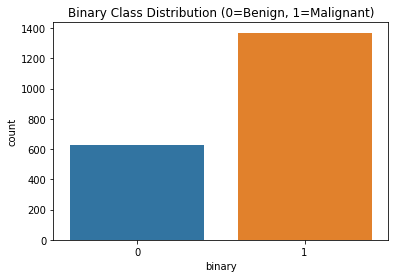

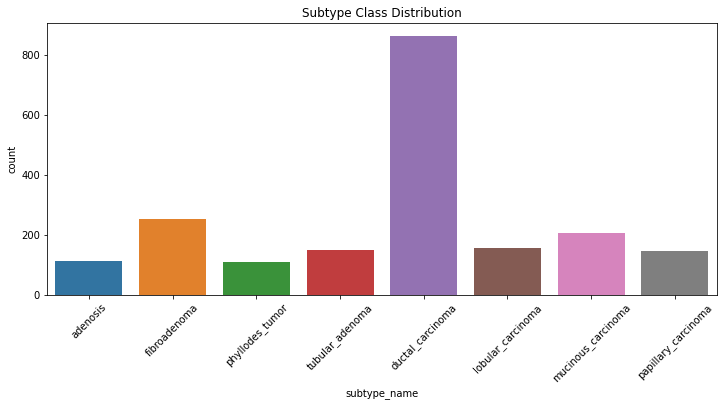

In [8]:
# Binary (main) class distribution
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='binary')
plt.title("Binary Class Distribution (0=Benign, 1=Malignant)")
plt.show()

# Subtype class distribution
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='subtype_name', order=label_to_subtype.values())
plt.title("Subtype Class Distribution")
plt.xticks(rotation=45)
plt.show()

In [9]:
def plot_subtype_samples(df, n_per_subtype=2, img_size=(128, 128)):
    """
    Displays n_per_subtype images for each class, organized by subtype.
    """
    subtypes = df['subtype'].unique()
    subtypes = sorted(subtypes, key=lambda x: subtype_to_label[x])  # preserve order

    num_subtypes = len(subtypes)
    cols = n_per_subtype
    rows = num_subtypes

    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    fig.suptitle(f'{n_per_subtype} Sample Images per Subtype', fontsize=16)

    for i, subtype in enumerate(subtypes):
        subset = df[df['subtype'] == subtype].sample(n=n_per_subtype, random_state=SEED)
        for j in range(n_per_subtype):
            ax = axes[i, j] if n_per_subtype > 1 else axes[i]
            img = Image.open(subset.iloc[j]['path']).convert('RGB').resize(img_size)
            ax.imshow(img)
            ax.set_title(f"{subtype}")
            ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.98])
    plt.show()

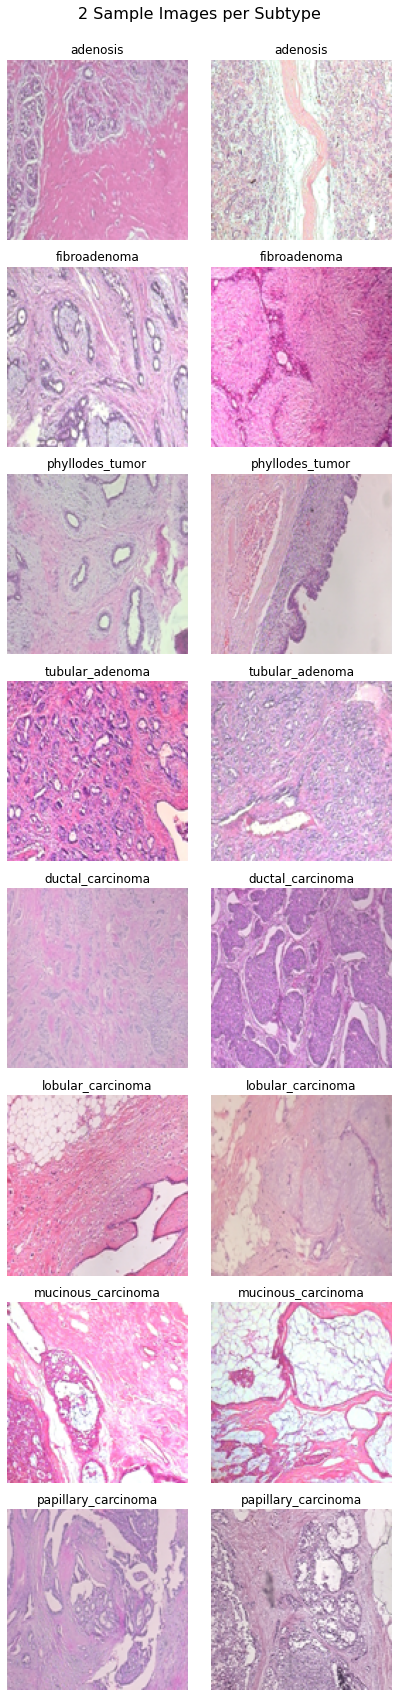

In [10]:
plot_subtype_samples(df, n_per_subtype=2, img_size=(128, 128))

In [11]:
def plot_rgb_histograms_grouped(df, bins=32):
    """
    Plot RGB histograms for 1 sample per subtype, grouped in two columns:
    Left = Benign, Right = Malignant. Title: 'Type - Subtype'.
    """
    # Organize subtypes
    benign_subtypes = ['adenosis', 'fibroadenoma', 'phyllodes_tumor', 'tubular_adenoma']
    malignant_subtypes = ['ductal_carcinoma', 'lobular_carcinoma', 'mucinous_carcinoma', 'papillary_carcinoma']

    all_subtypes = benign_subtypes + malignant_subtypes
    n_rows = max(len(benign_subtypes), len(malignant_subtypes))
    fig, axes = plt.subplots(n_rows, 2, figsize=(10, n_rows * 3))

    for i in range(n_rows):
        for j, (category, subtype_list) in enumerate([('Benign', benign_subtypes), ('Malignant', malignant_subtypes)]):
            if i >= len(subtype_list):
                axes[i, j].axis('off')
                continue
            subtype = subtype_list[i]
            sample = df[df['subtype'] == subtype].sample(n=1, random_state=SEED)
            img = Image.open(sample.iloc[0]['path']).convert('RGB').resize((224, 224))
            r, g, b = img.split()
            axes[i, j].hist(np.array(r).flatten(), bins=bins, alpha=0.5, color='r', label='R')
            axes[i, j].hist(np.array(g).flatten(), bins=bins, alpha=0.5, color='g', label='G')
            axes[i, j].hist(np.array(b).flatten(), bins=bins, alpha=0.5, color='b', label='B')
            axes[i, j].set_title(f"{category} - {subtype.replace('_', ' ').title()}")
            axes[i, j].set_xlim(0, 255)
            axes[i, j].set_xticks([])
            axes[i, j].set_yticks([])
            if i == 0 and j == 0:
                axes[i, j].legend()

    plt.suptitle("RGB Histogram per Subtype (Grouped by Type)", fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

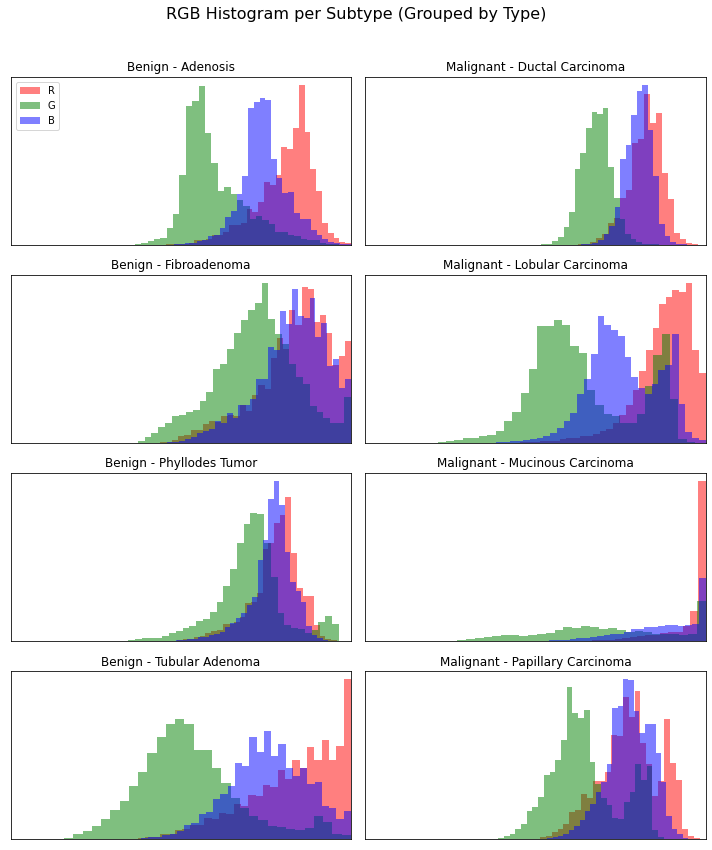

In [12]:
# Choose any 4 distinct subtypes
sample_subtypes = ['adenosis', 'fibroadenoma', 'ductal_carcinoma', 'mucinous_carcinoma']
plot_rgb_histograms_grouped(df)

In [13]:
def compute_mean_rgb_by_subtype(df, img_size=(128, 128)):
    stats = []

    for subtype in df['subtype'].unique():
        subset = df[df['subtype'] == subtype].sample(n=10, random_state=SEED)
        r_vals, g_vals, b_vals = [], [], []
        
        for path in subset['path']:
            img = Image.open(path).convert('RGB').resize(img_size)
            r, g, b = img.split()
            r_vals.append(np.array(r).mean())
            g_vals.append(np.array(g).mean())
            b_vals.append(np.array(b).mean())

        stats.append({
            'subtype': subtype,
            'R_mean': np.mean(r_vals),
            'G_mean': np.mean(g_vals),
            'B_mean': np.mean(b_vals),
        })

    return pd.DataFrame(stats).sort_values(by='subtype')

mean_rgb_df = compute_mean_rgb_by_subtype(df)
mean_rgb_df

subtype      R_mean      G_mean      B_mean
0             adenosis  201.443719  186.979401  198.493201
6     ductal_carcinoma  209.326129  146.689240  197.325623
3         fibroadenoma  207.175311  169.618945  198.607916
4    lobular_carcinoma  225.376648  160.094208  196.096930
5   mucinous_carcinoma  217.997003  178.208954  211.419397
7  papillary_carcinoma  207.458887  175.141620  199.284131
1      phyllodes_tumor  195.934045  174.767249  188.275885
2      tubular_adenoma  202.944507  156.529486  196.444684

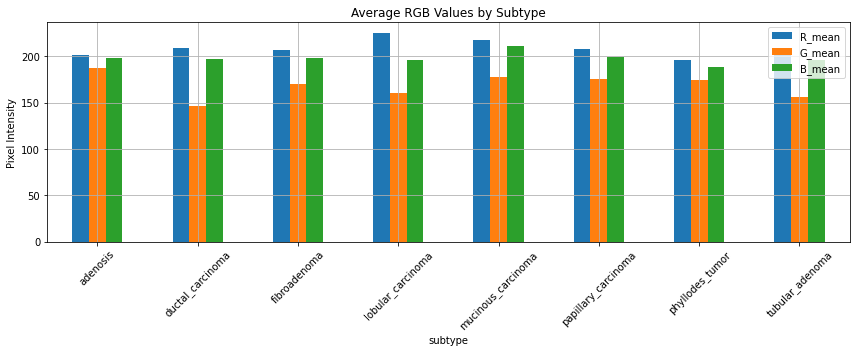

In [14]:
mean_rgb_df.set_index('subtype')[['R_mean', 'G_mean', 'B_mean']].plot(kind='bar', figsize=(12, 5))
plt.title("Average RGB Values by Subtype")
plt.ylabel("Pixel Intensity")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
from sklearn.model_selection import train_test_split

# 1. Stratify by subtype for balanced subclass distribution
train_df, test_df = train_test_split(df, test_size=0.1, random_state=SEED, stratify=df['subclass'])
train_df, val_df = train_test_split(train_df, test_size=0.15, random_state=SEED, stratify=train_df['subclass'])  # 0.125 × 0.8 = 0.1

print(f"Train: {len(train_df)}  |  Val: {len(val_df)}  |  Test: {len(test_df)}")



# dependency issues with numpy version

Train: 1525  |  Val: 270  |  Test: 200


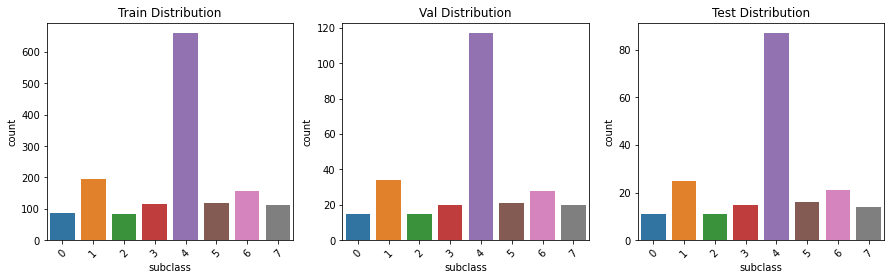

In [16]:
def plot_split_distribution(df_list, labels, label_type='subclass'):
    fig, axes = plt.subplots(1, len(df_list), figsize=(15, 4))
    for i, (df_split, label) in enumerate(zip(df_list, labels)):
        ax = axes[i]
        sns.countplot(data=df_split, x=label_type, ax=ax, order=sorted(df['subclass'].unique()))
        ax.set_title(f'{label} Distribution')
        ax.set_xlabel(label_type)
        ax.set_ylabel('count')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

plot_split_distribution([train_df, val_df, test_df], ['Train', 'Val', 'Test'], label_type='subclass')

In [17]:
def make_subset(df_split):
    return [(row['path'], row['binary'], row['subclass']) for _, row in df_split.iterrows()]

train_subset = make_subset(train_df)
val_subset = make_subset(val_df)
test_subset = make_subset(test_df)

In [18]:
class BreaKHisHierarchicalDataset(torch.utils.data.Dataset):
    def __init__(self, samples, transform=None):
        """
        samples: list of (image_path, binary_label, subclass_label)
        """
        self.samples = samples
        self.transform = transform

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, binary, subclass = self.samples[idx]
        image = Image.open(path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, binary, subclass

In [19]:
# Transforms
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

In [20]:
# Dataset instances
train_dataset = BreaKHisHierarchicalDataset(train_subset, transform=train_transform)
val_dataset   = BreaKHisHierarchicalDataset(val_subset, transform=val_test_transform)
test_dataset  = BreaKHisHierarchicalDataset(test_subset, transform=val_test_transform)

# DataLoaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [21]:
from torchvision.models import resnet18
import torch.nn as nn

def build_resnet18_model(num_classes):
    model = resnet18(weights='IMAGENET1K_V1')
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [24]:
def build_resnet18_model(num_classes):
    # Use 'pretrained=True' for older torchvision versions
    try:
        model = resnet18(weights='IMAGENET1K_V1')  # Newer versions
    except TypeError:
        model = resnet18(pretrained=True)  # Older versions
    
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    return model

In [25]:
NUM_BINARY_CLASSES = 2
NUM_SUBTYPE_CLASSES = 8

# Instantiate models
main_classifier = build_resnet18_model(NUM_BINARY_CLASSES)
sub_classifier = build_resnet18_model(NUM_SUBTYPE_CLASSES)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
main_classifier.to(device)
sub_classifier.to(device)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [27]:
from sklearn.metrics import accuracy_score
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=10, patience=3, task_type='binary'):
    best_model = None
    best_acc = 0.0
    epochs_no_improve = 0
    history = {'train_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for images, binary_labels, subclass_labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Train"):
            images = images.to(device)
            labels = binary_labels if task_type == 'binary' else subclass_labels
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        avg_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_loss)

        # Validation
        model.eval()
        y_true, y_pred = [], []
        with torch.no_grad():
            for images, binary_labels, subclass_labels in tqdm(val_loader, desc="Val"):
                images = images.to(device)
                labels = binary_labels if task_type == 'binary' else subclass_labels
                labels = labels.to(device)

                outputs = model(images)
                preds = torch.argmax(outputs, dim=1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_acc = accuracy_score(y_true, y_pred)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1} - Loss: {avg_loss:.4f} | Val Acc: {val_acc:.4f}")

        if val_acc > best_acc:
            best_acc = val_acc
            best_model = model.state_dict()
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    return best_model, history

In [28]:
main_criterion = nn.CrossEntropyLoss()
main_optimizer = torch.optim.Adam(main_classifier.parameters(), lr=1e-3)

best_main_model, history_main = train_model(
    model=main_classifier,
    train_loader=train_loader,
    val_loader=val_loader,
    criterion=main_criterion,
    optimizer=main_optimizer,
    num_epochs=10,
    patience=5,
    task_type='binary'
)

Epoch 2/10 - Train:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1 - Loss: 0.5628 | Val Acc: 0.7778


Epoch 3/10 - Train:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2 - Loss: 0.2958 | Val Acc: 0.8667


Epoch 4/10 - Train:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3 - Loss: 0.2535 | Val Acc: 0.9074


Epoch 5/10 - Train:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4 - Loss: 0.2341 | Val Acc: 0.7407


Epoch 6/10 - Train:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5 - Loss: 0.2449 | Val Acc: 0.8333


Epoch 7/10 - Train:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6 - Loss: 0.1731 | Val Acc: 0.8963


Epoch 8/10 - Train:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7 - Loss: 0.1696 | Val Acc: 0.7296


Val: 100%|██████████| 9/9 [00:17<00:00,  1.93s/it]

Epoch 8 - Loss: 0.2034 | Val Acc: 0.8889
Early stopping triggered.


In [29]:
import os
print(os.getcwd())
print(os.listdir())  # This will list files in current directory

/kaggle/working
[]


In [30]:
# If you want to save the entire model
torch.save(main_classifier, 'main_classifier_weighted_best.pth')

# OR if you only want to save weights
torch.save(main_classifier.state_dict(), 'main_classifier_weighted_best.pth')

In [31]:
# If you saved the entire model
main_classifier = torch.load('main_classifier_weighted_best.pth')

# If you saved only state_dict
main_classifier = build_resnet18_model(NUM_BINARY_CLASSES).to(device)
main_classifier.load_state_dict(torch.load('main_classifier_weighted_best.pth'))

<All keys matched successfully>

In [32]:
import os

# Optional: Create checkpoints directory if it doesn't exist
os.makedirs("checkpoints", exist_ok=True)

# Save model's state_dict
torch.save(main_classifier.state_dict(), "checkpoints/main_classifier_weighted_best.pth")

In [33]:
main_classifier.load_state_dict(torch.load("checkpoints/main_classifier_weighted_best.pth"))
main_classifier.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [34]:
y_true, y_pred = [],[]

In [35]:
with torch.no_grad():
    for images, binary_labels, _ in test_loader:
        images = images.to(device)
        labels = binary_labels.to(device)

        outputs = main_classifier(images)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

In [36]:
from sklearn.metrics import classification_report, accuracy_score

In [37]:
y_true, y_pred = [], []

with torch.no_grad():
    for images, binary_labels, _ in test_loader:
        images = images.to(device)
        labels = binary_labels.to(device)

        outputs = main_classifier(images)
        preds = torch.argmax(outputs, dim=1)

        y_true.extend(labels.cpu().numpy().tolist())
        y_pred.extend(preds.cpu().numpy().tolist())

In [38]:
print(f"Length of y_true: {len(y_true)}")
print(f"Length of y_pred: {len(y_pred)}")

Length of y_true: 200
Length of y_pred: 200


In [39]:
print(f"Batch size: {images.shape[0]} | Labels: {labels.shape} | Predictions: {preds.shape}")

Batch size: 8 | Labels: torch.Size([8]) | Predictions: torch.Size([8])


In [40]:
print("Weighted Main Classifier - Test Report:")
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))
print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")

Weighted Main Classifier - Test Report:
              precision    recall  f1-score   support

      Benign       0.89      0.87      0.88        62
   Malignant       0.94      0.95      0.95       138

    accuracy                           0.93       200
   macro avg       0.91      0.91      0.91       200
weighted avg       0.92      0.93      0.92       200

Accuracy: 0.9250


In [41]:
def plot_history(history, title='Training History'):
    epochs = range(1, len(history['train_loss']) + 1)

    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()

    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    ax2.plot(epochs, history['val_acc'], 'g-', label='Val Accuracy')

    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss', color='b')
    ax2.set_ylabel('Accuracy', color='g')

    fig.suptitle(title)
    fig.tight_layout()
    fig.legend(loc='upper right')
    plt.show()

In [42]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image

class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.model.eval()
        self.target_layer_name = target_layer_name
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self._register_hooks()
    
    def _register_hooks(self):
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        
        def forward_hook(module, input, output):
            self.activations = output
        
        # For ResNet-18, the target layer is typically 'layer4'
        target_layer = dict(self.model.named_modules())[self.target_layer_name]
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)
    
    def generate_cam(self, input_image, class_idx=None):
        # Forward pass
        model_output = self.model(input_image)
        
        if class_idx is None:
            class_idx = torch.argmax(model_output, dim=1)
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass
        class_score = model_output[:, class_idx].squeeze()
        class_score.backward(retain_graph=True)
        
        # Get gradients and activations
        gradients = self.gradients
        activations = self.activations
        
        # Pool the gradients across the channels
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        
        # Weight the channels by corresponding gradients
        for i in range(activations.size()[1]):
            activations[:, i, :, :] *= pooled_gradients[i]
        
        # Average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()
        
        # ReLU on top of the heatmap
        heatmap = F.relu(heatmap)
        
        # Normalize the heatmap
        heatmap /= torch.max(heatmap)
        
        return heatmap.detach()

def visualize_gradcam(model, image_tensor, original_image, class_names, target_layer='layer4', 
                     class_idx=None, alpha=0.4, save_path=None):
    """
    Visualize GradCAM for a given image
    
    Args:
        model: Trained PyTorch model
        image_tensor: Preprocessed image tensor (1, 3, 224, 224)
        original_image: Original PIL image for overlay
        class_names: List of class names
        target_layer: Target layer name for GradCAM
        class_idx: Target class index (if None, uses predicted class)
        alpha: Transparency for overlay
        save_path: Path to save the visualization
    """
    # Create GradCAM object
    grad_cam = GradCAM(model, target_layer)
    
    # Generate CAM
    heatmap = grad_cam.generate_cam(image_tensor, class_idx)
    
    # Get prediction
    with torch.no_grad():
        output = model(image_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
        confidence = F.softmax(output, dim=1)[0, predicted_class].item()
    
    # Convert heatmap to numpy
    heatmap_np = heatmap.cpu().numpy()
    
    # Resize heatmap to match original image size
    original_size = original_image.size
    heatmap_resized = cv2.resize(heatmap_np, original_size)
    
    # Convert to RGB
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Convert original image to numpy array
    original_np = np.array(original_image)
    
    # Create overlay
    overlay = heatmap_colored * alpha + original_np * (1 - alpha)
    overlay = np.uint8(overlay)
    
    # Create subplot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Heatmap
    axes[1].imshow(heatmap_resized, cmap='jet')
    axes[1].set_title('GradCAM Heatmap')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(overlay)
    axes[2].set_title(f'Prediction: {class_names[predicted_class]}\nConfidence: {confidence:.3f}')
    axes[2].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return heatmap_np, predicted_class, confidence

def batch_gradcam_analysis(model, dataset, class_names, num_samples=8, target_layer='layer4'):
    """
    Analyze multiple samples with GradCAM
    
    Args:
        model: Trained PyTorch model
        dataset: Dataset object
        class_names: List of class names
        num_samples: Number of samples to analyze
        target_layer: Target layer for GradCAM
    """
    model.eval()
    
    # Get random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))
    
    for i, idx in enumerate(indices):
        # Get image and labels
        image_tensor, binary_label, subclass_label = dataset[idx]
        
        # Add batch dimension
        image_tensor = image_tensor.unsqueeze(0).to(device)
        
        # Get original image for visualization
        original_path = dataset.samples[idx][0]
        original_image = Image.open(original_path).convert('RGB')
        
        # Generate GradCAM
        grad_cam = GradCAM(model, target_layer)
        heatmap = grad_cam.generate_cam(image_tensor)
        
        # Get prediction
        with torch.no_grad():
            output = model(image_tensor)
            predicted_class = torch.argmax(output, dim=1).item()
            confidence = F.softmax(output, dim=1)[0, predicted_class].item()
        
        # Convert heatmap to numpy and resize
        heatmap_np = heatmap.cpu().numpy()
        heatmap_resized = cv2.resize(heatmap_np, original_image.size)
        
        # Create overlay
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        original_np = np.array(original_image)
        overlay = heatmap_colored * 0.4 + original_np * 0.6
        overlay = np.uint8(overlay)
        
        # Plot original image
        axes[0, i].imshow(original_image)
        axes[0, i].set_title(f'True: {class_names[binary_label]}')
        axes[0, i].axis('off')
        
        # Plot GradCAM overlay
        axes[1, i].imshow(overlay)
        axes[1, i].set_title(f'Pred: {class_names[predicted_class]}\nConf: {confidence:.2f}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage examples:

# 1. Load your trained model (uncomment the appropriate line)
# main_classifier.load_state_dict(torch.load('main_classifier_weighted_best.pth'))
# main_classifier.eval()

# 2. Define class names
binary_class_names = ['Benign', 'Malignant']
subtype_class_names = list(label_to_subtype.values())

# 3. Single image GradCAM visualization
def analyze_single_image(model, dataset, idx, class_names, target_layer='layer4'):
    """
    Analyze a single image with GradCAM
    """
    # Get image and labels
    image_tensor, binary_label, subclass_label = dataset[idx]
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    # Get original image
    original_path = dataset.samples[idx][0]
    original_image = Image.open(original_path).convert('RGB')
    
    # Visualize
    heatmap, pred_class, confidence = visualize_gradcam(
        model, image_tensor, original_image, class_names, target_layer
    )
    
    print(f"True label: {class_names[binary_label]}")
    print(f"Predicted: {class_names[pred_class]} (confidence: {confidence:.3f})")
    
    return heatmap, pred_class, confidence

# 4. Compare binary vs subtype classification GradCAMs
def compare_binary_vs_subtype_gradcam(main_model, sub_model, dataset, idx):
    """
    Compare GradCAM visualizations between binary and subtype models
    """
    # Get image and labels
    image_tensor, binary_label, subclass_label = dataset[idx]
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    # Get original image
    original_path = dataset.samples[idx][0]
    original_image = Image.open(original_path).convert('RGB')
    
    # Generate GradCAMs for both models
    grad_cam_main = GradCAM(main_model, 'layer4')
    grad_cam_sub = GradCAM(sub_model, 'layer4')
    
    heatmap_main = grad_cam_main.generate_cam(image_tensor)
    heatmap_sub = grad_cam_sub.generate_cam(image_tensor)
    
    # Get predictions
    with torch.no_grad():
        output_main = main_model(image_tensor)
        output_sub = sub_model(image_tensor)
        
        pred_main = torch.argmax(output_main, dim=1).item()
        pred_sub = torch.argmax(output_sub, dim=1).item()
        
        conf_main = F.softmax(output_main, dim=1)[0, pred_main].item()
        conf_sub = F.softmax(output_sub, dim=1)[0, pred_sub].item()
    
    # Convert heatmaps to numpy
    heatmap_main_np = heatmap_main.cpu().numpy()
    heatmap_sub_np = heatmap_sub.cpu().numpy()
    
    # Resize heatmaps
    heatmap_main_resized = cv2.resize(heatmap_main_np, original_image.size)
    heatmap_sub_resized = cv2.resize(heatmap_sub_np, original_image.size)
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original image
    axes[0, 0].imshow(original_image)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[1, 0].imshow(original_image)
    axes[1, 0].set_title('Original Image')
    axes[1, 0].axis('off')
    
    # Binary model results
    axes[0, 1].imshow(heatmap_main_resized, cmap='jet')
    axes[0, 1].set_title(f'Binary GradCAM\nPred: {binary_class_names[pred_main]}')
    axes[0, 1].axis('off')
    
    # Create overlay for binary
    heatmap_colored_main = cv2.applyColorMap(np.uint8(255 * heatmap_main_resized), cv2.COLORMAP_JET)
    heatmap_colored_main = cv2.cvtColor(heatmap_colored_main, cv2.COLOR_BGR2RGB)
    original_np = np.array(original_image)
    overlay_main = heatmap_colored_main * 0.4 + original_np * 0.6
    overlay_main = np.uint8(overlay_main)
    
    axes[0, 2].imshow(overlay_main)
    axes[0, 2].set_title(f'Binary Overlay\nConf: {conf_main:.3f}')
    axes[0, 2].axis('off')
    
    # Subtype model results
    axes[1, 1].imshow(heatmap_sub_resized, cmap='jet')
    axes[1, 1].set_title(f'Subtype GradCAM\nPred: {subtype_class_names[pred_sub]}')
    axes[1, 1].axis('off')
    
    # Create overlay for subtype
    heatmap_colored_sub = cv2.applyColorMap(np.uint8(255 * heatmap_sub_resized), cv2.COLORMAP_JET)
    heatmap_colored_sub = cv2.cvtColor(heatmap_colored_sub, cv2.COLOR_BGR2RGB)
    overlay_sub = heatmap_colored_sub * 0.4 + original_np * 0.6
    overlay_sub = np.uint8(overlay_sub)
    
    axes[1, 2].imshow(overlay_sub)
    axes[1, 2].set_title(f'Subtype Overlay\nConf: {conf_sub:.3f}')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"True binary label: {binary_class_names[binary_label]}")
    print(f"True subtype: {subtype_class_names[subclass_label]}")

# Example usage (uncomment to use):
# analyze_single_image(main_classifier, test_dataset, 0, binary_class_names)
# batch_gradcam_analysis(main_classifier, test_dataset, binary_class_names, num_samples=6)
# compare_binary_vs_subtype_gradcam(main_classifier, sub_classifier, test_dataset, 0)

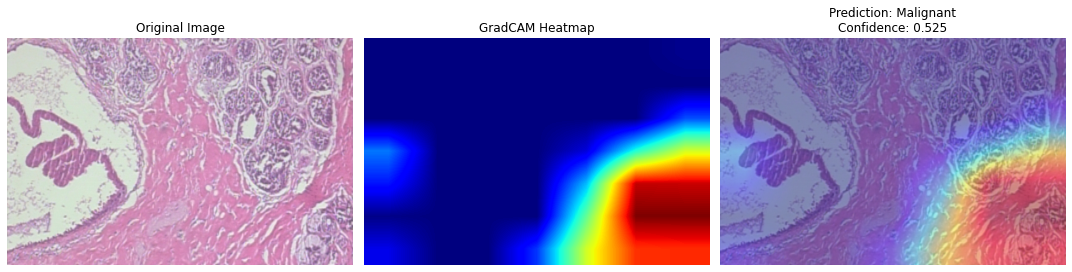

True label: Benign
Predicted: Malignant (confidence: 0.525)


(array([[0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.01496345],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.        ],
        [0.        , 0.        , 0.        , 0.        , 0.        ,
         0.        , 0.2037764 ],
        [0.24270478, 0.        , 0.        , 0.        , 0.08178858,
         0.39306235, 0.60638297],
        [0.1427124 , 0.        , 0.        , 0.        , 0.30980793,
         0.93987954, 0.9347469 ],
        [0.0094385 , 0.        , 0.        , 0.        , 0.46980885,
         1.        , 0.99966115],
        [0.09411865, 0.        , 0.        , 0.17721908, 0.60306096,
         0.85864645, 0.86514544]], dtype=float32),
 1,
 0.5245136022567749)

In [43]:
binary_class_names = ['Benign', 'Malignant']
analyze_single_image(main_classifier, test_dataset, 0, binary_class_names)

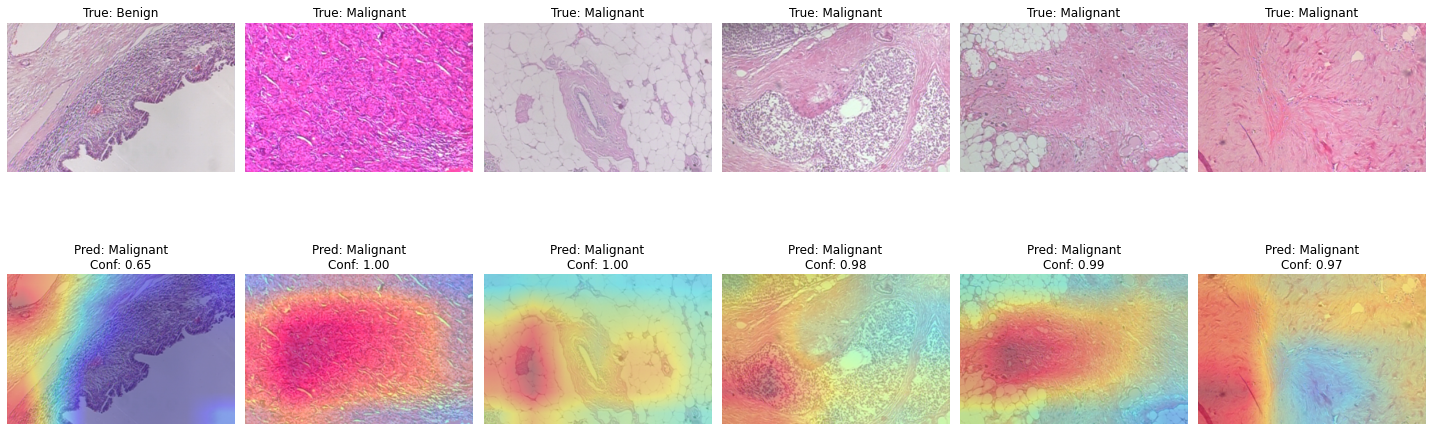

In [44]:
batch_gradcam_analysis(main_classifier, test_dataset, binary_class_names, num_samples=6)

In [45]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image

class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.model.eval()
        self.target_layer_name = target_layer_name
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self._register_hooks()
    
    def _register_hooks(self):
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        
        def forward_hook(module, input, output):
            self.activations = output
        
        # For ResNet-18, the target layer is typically 'layer4'
        target_layer = dict(self.model.named_modules())[self.target_layer_name]
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)
    
    def generate_cam(self, input_image, class_idx=None):
        # Forward pass
        model_output = self.model(input_image)
        
        if class_idx is None:
            class_idx = torch.argmax(model_output, dim=1)
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass
        class_score = model_output[:, class_idx].squeeze()
        class_score.backward(retain_graph=True)
        
        # Get gradients and activations
        gradients = self.gradients
        activations = self.activations
        
        # Pool the gradients across the channels
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        
        # Weight the channels by corresponding gradients
        for i in range(activations.size()[1]):
            activations[:, i, :, :] *= pooled_gradients[i]
        
        # Average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()
        
        # ReLU on top of the heatmap
        heatmap = F.relu(heatmap)
        
        # Normalize the heatmap
        heatmap /= torch.max(heatmap)
        
        return heatmap.detach()

def visualize_gradcam(model, image_tensor, original_image, class_names, target_layer='layer4', 
                     class_idx=None, alpha=0.4, save_path=None):
    """
    Visualize GradCAM for a given image
    
    Args:
        model: Trained PyTorch model
        image_tensor: Preprocessed image tensor (1, 3, 224, 224)
        original_image: Original PIL image for overlay
        class_names: List of class names
        target_layer: Target layer name for GradCAM
        class_idx: Target class index (if None, uses predicted class)
        alpha: Transparency for overlay
        save_path: Path to save the visualization
    """
    # Create GradCAM object
    grad_cam = GradCAM(model, target_layer)
    
    # Generate CAM
    heatmap = grad_cam.generate_cam(image_tensor, class_idx)
    
    # Get prediction
    with torch.no_grad():
        output = model(image_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
        confidence = F.softmax(output, dim=1)[0, predicted_class].item()
    
    # Convert heatmap to numpy
    heatmap_np = heatmap.cpu().numpy()
    
    # Resize heatmap to match original image size
    original_size = original_image.size
    heatmap_resized = cv2.resize(heatmap_np, original_size)
    
    # Convert to RGB
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Convert original image to numpy array
    original_np = np.array(original_image)
    
    # Create overlay
    overlay = heatmap_colored * alpha + original_np * (1 - alpha)
    overlay = np.uint8(overlay)
    
    # Create subplot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Heatmap
    axes[1].imshow(heatmap_resized, cmap='jet')
    axes[1].set_title('GradCAM Heatmap')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(overlay)
    axes[2].set_title(f'Prediction: {class_names[predicted_class]}\nConfidence: {confidence:.3f}')
    axes[2].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return heatmap_np, predicted_class, confidence

def batch_gradcam_analysis(model, dataset, class_names, num_samples=8, target_layer='layer4'):
    """
    Analyze multiple samples with GradCAM
    
    Args:
        model: Trained PyTorch model
        dataset: Dataset object
        class_names: List of class names
        num_samples: Number of samples to analyze
        target_layer: Target layer for GradCAM
    """
    model.eval()
    
    # Get random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))
    
    for i, idx in enumerate(indices):
        # Get image and labels
        image_tensor, binary_label, subclass_label = dataset[idx]
        
        # Add batch dimension
        image_tensor = image_tensor.unsqueeze(0).to(device)
        
        # Get original image for visualization
        original_path = dataset.samples[idx][0]
        original_image = Image.open(original_path).convert('RGB')
        
        # Generate GradCAM
        grad_cam = GradCAM(model, target_layer)
        heatmap = grad_cam.generate_cam(image_tensor)
        
        # Get prediction
        with torch.no_grad():
            output = model(image_tensor)
            predicted_class = torch.argmax(output, dim=1).item()
            confidence = F.softmax(output, dim=1)[0, predicted_class].item()
        
        # Convert heatmap to numpy and resize
        heatmap_np = heatmap.cpu().numpy()
        heatmap_resized = cv2.resize(heatmap_np, original_image.size)
        
        # Create overlay
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        original_np = np.array(original_image)
        overlay = heatmap_colored * 0.4 + original_np * 0.6
        overlay = np.uint8(overlay)
        
        # Plot original image
        axes[0, i].imshow(original_image)
        axes[0, i].set_title(f'True: {class_names[binary_label]}')
        axes[0, i].axis('off')
        
        # Plot GradCAM overlay
        axes[1, i].imshow(overlay)
        axes[1, i].set_title(f'Pred: {class_names[predicted_class]}\nConf: {confidence:.2f}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage examples:

# 1. Load your trained model (uncomment the appropriate line)
# main_classifier.load_state_dict(torch.load('main_classifier_weighted_best.pth'))
# main_classifier.eval()

# 2. Define class names
binary_class_names = ['Benign', 'Malignant']
subtype_class_names = list(label_to_subtype.values())

# 3. Single image GradCAM visualization
def analyze_single_image(model, dataset, idx, class_names, target_layer='layer4'):
    """
    Analyze a single image with GradCAM
    """
    # Get image and labels
    image_tensor, binary_label, subclass_label = dataset[idx]
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    # Get original image
    original_path = dataset.samples[idx][0]
    original_image = Image.open(original_path).convert('RGB')
    
    # Visualize
    heatmap, pred_class, confidence = visualize_gradcam(
        model, image_tensor, original_image, class_names, target_layer
    )
    
    print(f"True label: {class_names[binary_label]}")
    print(f"Predicted: {class_names[pred_class]} (confidence: {confidence:.3f})")
    
    return heatmap, pred_class, confidence

# 4. Compare binary vs subtype classification GradCAMs
def compare_binary_vs_subtype_gradcam(main_model, sub_model, dataset, idx):
    """
    Compare GradCAM visualizations between binary and subtype models
    """
    # Get image and labels
    image_tensor, binary_label, subclass_label = dataset[idx]
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    # Get original image
    original_path = dataset.samples[idx][0]
    original_image = Image.open(original_path).convert('RGB')
    
    # Generate GradCAMs for both models
    grad_cam_main = GradCAM(main_model, 'layer4')
    grad_cam_sub = GradCAM(sub_model, 'layer4')
    
    heatmap_main = grad_cam_main.generate_cam(image_tensor)
    heatmap_sub = grad_cam_sub.generate_cam(image_tensor)
    
    # Get predictions
    with torch.no_grad():
        output_main = main_model(image_tensor)
        output_sub = sub_model(image_tensor)
        
        pred_main = torch.argmax(output_main, dim=1).item()
        pred_sub = torch.argmax(output_sub, dim=1).item()
        
        conf_main = F.softmax(output_main, dim=1)[0, pred_main].item()
        conf_sub = F.softmax(output_sub, dim=1)[0, pred_sub].item()
    
    # Convert heatmaps to numpy
    heatmap_main_np = heatmap_main.cpu().numpy()
    heatmap_sub_np = heatmap_sub.cpu().numpy()
    
    # Resize heatmaps
    heatmap_main_resized = cv2.resize(heatmap_main_np, original_image.size)
    heatmap_sub_resized = cv2.resize(heatmap_sub_np, original_image.size)
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original image
    axes[0, 0].imshow(original_image)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[1, 0].imshow(original_image)
    axes[1, 0].set_title('Original Image')
    axes[1, 0].axis('off')
    
    # Binary model results
    axes[0, 1].imshow(heatmap_main_resized, cmap='jet')
    axes[0, 1].set_title(f'Binary GradCAM\nPred: {binary_class_names[pred_main]}')
    axes[0, 1].axis('off')
    
    # Create overlay for binary
    heatmap_colored_main = cv2.applyColorMap(np.uint8(255 * heatmap_main_resized), cv2.COLORMAP_JET)
    heatmap_colored_main = cv2.cvtColor(heatmap_colored_main, cv2.COLOR_BGR2RGB)
    original_np = np.array(original_image)
    overlay_main = heatmap_colored_main * 0.4 + original_np * 0.6
    overlay_main = np.uint8(overlay_main)
    
    axes[0, 2].imshow(overlay_main)
    axes[0, 2].set_title(f'Binary Overlay\nConf: {conf_main:.3f}')
    axes[0, 2].axis('off')
    
    # Subtype model results
    axes[1, 1].imshow(heatmap_sub_resized, cmap='jet')
    axes[1, 1].set_title(f'Subtype GradCAM\nPred: {subtype_class_names[pred_sub]}')
    axes[1, 1].axis('off')
    
    # Create overlay for subtype
    heatmap_colored_sub = cv2.applyColorMap(np.uint8(255 * heatmap_sub_resized), cv2.COLORMAP_JET)
    heatmap_colored_sub = cv2.cvtColor(heatmap_colored_sub, cv2.COLOR_BGR2RGB)
    overlay_sub = heatmap_colored_sub * 0.4 + original_np * 0.6
    overlay_sub = np.uint8(overlay_sub)
    
    axes[1, 2].imshow(overlay_sub)
    axes[1, 2].set_title(f'Subtype Overlay\nConf: {conf_sub:.3f}')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"True binary label: {binary_class_names[binary_label]}")
    print(f"True subtype: {subtype_class_names[subclass_label]}")

# Additional Verification and Analysis Functions

def verify_gradcam_sanity_check(model, dataset, idx, class_names, target_layer='layer4'):
    """
    Sanity check: GradCAM should change when we modify the target class
    """
    # Get image
    image_tensor, binary_label, subclass_label = dataset[idx]
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    # Get original image
    original_path = dataset.samples[idx][0]
    original_image = Image.open(original_path).convert('RGB')
    
    # Create GradCAM
    grad_cam = GradCAM(model, target_layer)
    
    # Generate CAM for predicted class
    heatmap_pred = grad_cam.generate_cam(image_tensor, class_idx=None)
    
    # Generate CAM for opposite class (0->1, 1->0)
    with torch.no_grad():
        output = model(image_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
    
    opposite_class = 1 - predicted_class
    heatmap_opposite = grad_cam.generate_cam(image_tensor, class_idx=opposite_class)
    
    # Convert to numpy
    heatmap_pred_np = heatmap_pred.cpu().numpy()
    heatmap_opposite_np = heatmap_opposite.cpu().numpy()
    
    # Resize heatmaps
    heatmap_pred_resized = cv2.resize(heatmap_pred_np, original_image.size)
    heatmap_opposite_resized = cv2.resize(heatmap_opposite_np, original_image.size)
    
    # Create visualization
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Original
    axes[0].imshow(original_image)
    axes[0].set_title(f'Original\nTrue: {class_names[binary_label]}')
    axes[0].axis('off')
    
    # Predicted class heatmap
    axes[1].imshow(heatmap_pred_resized, cmap='jet')
    axes[1].set_title(f'GradCAM for Predicted Class\n({class_names[predicted_class]})')
    axes[1].axis('off')
    
    # Opposite class heatmap
    axes[2].imshow(heatmap_opposite_resized, cmap='jet')
    axes[2].set_title(f'GradCAM for Opposite Class\n({class_names[opposite_class]})')
    axes[2].axis('off')
    
    # Difference map
    diff_map = np.abs(heatmap_pred_resized - heatmap_opposite_resized)
    axes[3].imshow(diff_map, cmap='viridis')
    axes[3].set_title('Difference Map\n(Should show distinct patterns)')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation (should be low for good GradCAM)
    correlation = np.corrcoef(heatmap_pred_resized.flatten(), heatmap_opposite_resized.flatten())[0, 1]
    print(f"Correlation between heatmaps: {correlation:.3f}")
    print("Good GradCAM should have low correlation (< 0.5) between different classes")

def analyze_gradcam_statistics(model, dataset, class_names, num_samples=50, target_layer='layer4'):
    """
    Statistical analysis of GradCAM activations across multiple samples
    """
    model.eval()
    grad_cam = GradCAM(model, target_layer)
    
    benign_activations = []
    malignant_activations = []
    
    # Randomly sample images
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    print("Analyzing GradCAM statistics...")
    for idx in tqdm(indices):
        image_tensor, binary_label, _ = dataset[idx]
        image_tensor = image_tensor.unsqueeze(0).to(device)
        
        # Generate heatmap
        heatmap = grad_cam.generate_cam(image_tensor)
        heatmap_np = heatmap.cpu().numpy()
        
        # Calculate statistics
        mean_activation = np.mean(heatmap_np)
        max_activation = np.max(heatmap_np)
        std_activation = np.std(heatmap_np)
        
        stats = {
            'mean': mean_activation,
            'max': max_activation,
            'std': std_activation,
            'sparsity': np.sum(heatmap_np > 0.5) / heatmap_np.size  # Proportion of high activations
        }
        
        if binary_label == 0:  # Benign
            benign_activations.append(stats)
        else:  # Malignant
            malignant_activations.append(stats)
    
    # Convert to DataFrames
    benign_df = pd.DataFrame(benign_activations)
    malignant_df = pd.DataFrame(malignant_activations)
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    metrics = ['mean', 'max', 'std', 'sparsity']
    titles = ['Mean Activation', 'Max Activation', 'Std Activation', 'Activation Sparsity']
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[i//2, i%2]
        
        # Plot distributions
        ax.hist(benign_df[metric], alpha=0.7, label='Benign', bins=15, color='blue')
        ax.hist(malignant_df[metric], alpha=0.7, label='Malignant', bins=15, color='red')
        
        ax.set_title(f'{title} Distribution')
        ax.set_xlabel(metric)
        ax.set_ylabel('Frequency')
        ax.legend()
        
        # Add statistical test
        from scipy.stats import ttest_ind
        t_stat, p_value = ttest_ind(benign_df[metric], malignant_df[metric])
        ax.text(0.02, 0.98, f'p-value: {p_value:.4f}', transform=ax.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nGradCAM Statistics Summary:")
    print("-" * 50)
    print("BENIGN:")
    print(benign_df.describe())
    print("\nMALIGNANT:")
    print(malignant_df.describe())

def visualize_layer_comparison(model, dataset, idx, class_names):
    """
    Compare GradCAM across different ResNet layers
    """
    # ResNet-18 layer names
    layers = ['layer1', 'layer2', 'layer3', 'layer4']
    
    # Get image
    image_tensor, binary_label, _ = dataset[idx]
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    # Get original image
    original_path = dataset.samples[idx][0]
    original_image = Image.open(original_path).convert('RGB')
    
    # Get prediction
    with torch.no_grad():
        output = model(image_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
        confidence = F.softmax(output, dim=1)[0, predicted_class].item()
    
    # Create subplots
    fig, axes = plt.subplots(1, len(layers) + 1, figsize=(20, 4))
    
    # Original image
    axes[0].imshow(original_image)
    axes[0].set_title(f'Original\nTrue: {class_names[binary_label]}\nPred: {class_names[predicted_class]} ({confidence:.2f})')
    axes[0].axis('off')
    
    # Generate GradCAM for each layer
    for i, layer in enumerate(layers):
        grad_cam = GradCAM(model, layer)
        heatmap = grad_cam.generate_cam(image_tensor)
        heatmap_np = heatmap.cpu().numpy()
        heatmap_resized = cv2.resize(heatmap_np, original_image.size)
        
        axes[i+1].imshow(heatmap_resized, cmap='jet')
        axes[i+1].set_title(f'{layer}\nResolution: {heatmap_np.shape}')
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("Layer Comparison:")
    print("- Earlier layers (layer1, layer2) show low-level features")
    print("- Later layers (layer3, layer4) show high-level semantic features")
    print("- layer4 typically provides the best class-discriminative visualizations")

def gradcam_confidence_analysis(model, dataset, class_names, num_samples=100, target_layer='layer4'):
    """
    Analyze relationship between model confidence and GradCAM activation patterns
    """
    model.eval()
    grad_cam = GradCAM(model, target_layer)
    
    results = []
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    print("Analyzing confidence vs GradCAM patterns...")
    for idx in tqdm(indices):
        image_tensor, binary_label, _ = dataset[idx]
        image_tensor = image_tensor.unsqueeze(0).to(device)
        
        # Get prediction and confidence
        with torch.no_grad():
            output = model(image_tensor)
            predicted_class = torch.argmax(output, dim=1).item()
            confidence = F.softmax(output, dim=1)[0, predicted_class].item()
        
        # Generate heatmap
        heatmap = grad_cam.generate_cam(image_tensor)
        heatmap_np = heatmap.cpu().numpy()
        
        # Calculate heatmap metrics
        max_activation = np.max(heatmap_np)
        mean_activation = np.mean(heatmap_np)
        activation_entropy = -np.sum(heatmap_np * np.log(heatmap_np + 1e-10))  # Entropy measure
        
        results.append({
            'confidence': confidence,
            'max_activation': max_activation,
            'mean_activation': mean_activation,
            'entropy': activation_entropy,
            'correct': predicted_class == binary_label
        })
    
    results_df = pd.DataFrame(results)
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Confidence vs Max Activation
    correct = results_df[results_df['correct'] == True]
    incorrect = results_df[results_df['correct'] == False]
    
    axes[0, 0].scatter(correct['confidence'], correct['max_activation'], 
                      alpha=0.6, label='Correct', color='green')
    axes[0, 0].scatter(incorrect['confidence'], incorrect['max_activation'], 
                      alpha=0.6, label='Incorrect', color='red')
    axes[0, 0].set_xlabel('Model Confidence')
    axes[0, 0].set_ylabel('Max GradCAM Activation')
    axes[0, 0].set_title('Confidence vs Max Activation')
    axes[0, 0].legend()
    
    # Confidence vs Mean Activation
    axes[0, 1].scatter(correct['confidence'], correct['mean_activation'], 
                      alpha=0.6, label='Correct', color='green')
    axes[0, 1].scatter(incorrect['confidence'], incorrect['mean_activation'], 
                      alpha=0.6, label='Incorrect', color='red')
    axes[0, 1].set_xlabel('Model Confidence')
    axes[0, 1].set_ylabel('Mean GradCAM Activation')
    axes[0, 1].set_title('Confidence vs Mean Activation')
    axes[0, 1].legend()
    
    # Confidence distribution
    axes[1, 0].hist(correct['confidence'], alpha=0.7, label='Correct', bins=20, color='green')
    axes[1, 0].hist(incorrect['confidence'], alpha=0.7, label='Incorrect', bins=20, color='red')
    axes[1, 0].set_xlabel('Model Confidence')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Confidence Distribution')
    axes[1, 0].legend()
    
    # Activation entropy vs confidence
    axes[1, 1].scatter(correct['confidence'], correct['entropy'], 
                      alpha=0.6, label='Correct', color='green')
    axes[1, 1].scatter(incorrect['confidence'], incorrect['entropy'], 
                      alpha=0.6, label='Incorrect', color='red')
    axes[1, 1].set_xlabel('Model Confidence')
    axes[1, 1].set_ylabel('Activation Entropy')
    axes[1, 1].set_title('Confidence vs Activation Entropy')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print correlation analysis
    print("Correlation Analysis:")
    print(f"Confidence vs Max Activation: {np.corrcoef(results_df['confidence'], results_df['max_activation'])[0,1]:.3f}")
    print(f"Confidence vs Mean Activation: {np.corrcoef(results_df['confidence'], results_df['mean_activation'])[0,1]:.3f}")
    print(f"Confidence vs Entropy: {np.corrcoef(results_df['confidence'], results_df['entropy'])[0,1]:.3f}")

# Example usage for verification:
print("Additional GradCAM Verification Functions Added!")
print("\nUsage examples:")
print("1. verify_gradcam_sanity_check(main_classifier, test_dataset, 0, binary_class_names)")
print("2. analyze_gradcam_statistics(main_classifier, test_dataset, binary_class_names)")
print("3. visualize_layer_comparison(main_classifier, test_dataset, 0, binary_class_names)")
print("4. gradcam_confidence_analysis(main_classifier, test_dataset, binary_class_names)")

# Example usage (uncomment to use):
# analyze_single_image(main_classifier, test_dataset, 0, binary_class_names)
# batch_gradcam_analysis(main_classifier, test_dataset, binary_class_names, num_samples=6)
# compare_binary_vs_subtype_gradcam(main_classifier, sub_classifier, test_dataset, 0)

Additional GradCAM Verification Functions Added!

Usage examples:
1. verify_gradcam_sanity_check(main_classifier, test_dataset, 0, binary_class_names)
2. analyze_gradcam_statistics(main_classifier, test_dataset, binary_class_names)
3. visualize_layer_comparison(main_classifier, test_dataset, 0, binary_class_names)
4. gradcam_confidence_analysis(main_classifier, test_dataset, binary_class_names)


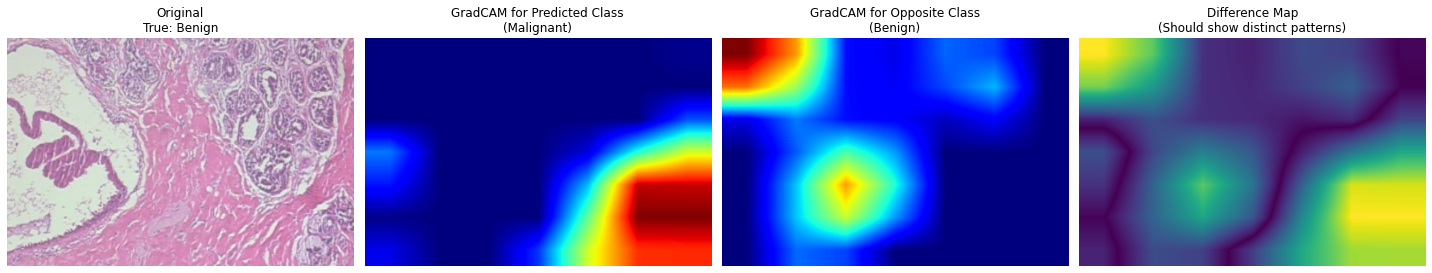

Correlation between heatmaps: -0.486
Good GradCAM should have low correlation (< 0.5) between different classes


In [46]:
binary_class_names = ['Benign', 'Malignant'] 
verify_gradcam_sanity_check(main_classifier, test_dataset, 0, binary_class_names)

  0%|          | 0/50 [00:00<?, ?it/s]

Analyzing GradCAM statistics...


100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


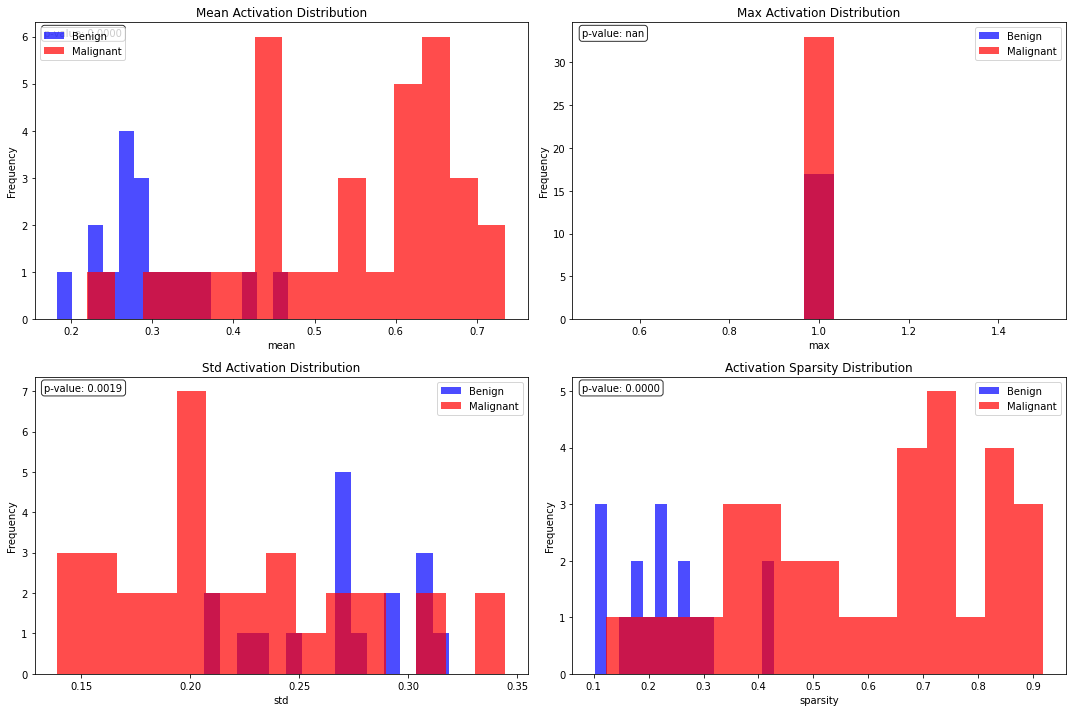


GradCAM Statistics Summary:
--------------------------------------------------
BENIGN:
            mean   max        std   sparsity
count  17.000000  17.0  17.000000  17.000000
mean    0.297376   1.0   0.269840   0.231693
std     0.072124   0.0   0.035044   0.092385
min     0.182590   1.0   0.206391   0.102041
25%     0.258613   1.0   0.244171   0.183673
50%     0.279320   1.0   0.271403   0.224490
75%     0.332554   1.0   0.294878   0.265306
max     0.467339   1.0   0.318774   0.428571

MALIGNANT:
            mean   max        std   sparsity
count  33.000000  33.0  33.000000  33.000000
mean    0.546492   1.0   0.220745   0.593692
std     0.128251   0.0   0.056196   0.220769
min     0.220021   1.0   0.138988   0.122449
25%     0.446606   1.0   0.181380   0.387755
50%     0.596548   1.0   0.204844   0.653061
75%     0.645116   1.0   0.249298   0.755102
max     0.735085   1.0   0.344628   0.918367


In [47]:
analyze_gradcam_statistics(main_classifier, test_dataset, binary_class_names, num_samples=50)

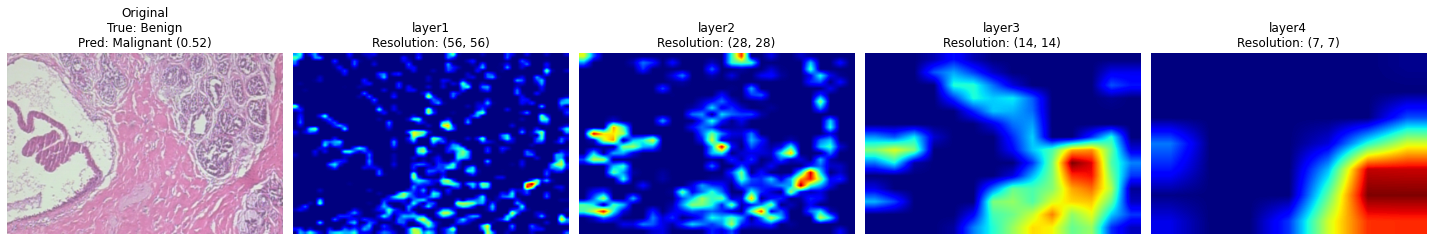

Layer Comparison:
- Earlier layers (layer1, layer2) show low-level features
- Later layers (layer3, layer4) show high-level semantic features
- layer4 typically provides the best class-discriminative visualizations


In [48]:
visualize_layer_comparison(main_classifier, test_dataset, 0, binary_class_names)

  0%|          | 0/100 [00:00<?, ?it/s]

Analyzing confidence vs GradCAM patterns...


100%|██████████| 100/100 [00:28<00:00,  3.51it/s]


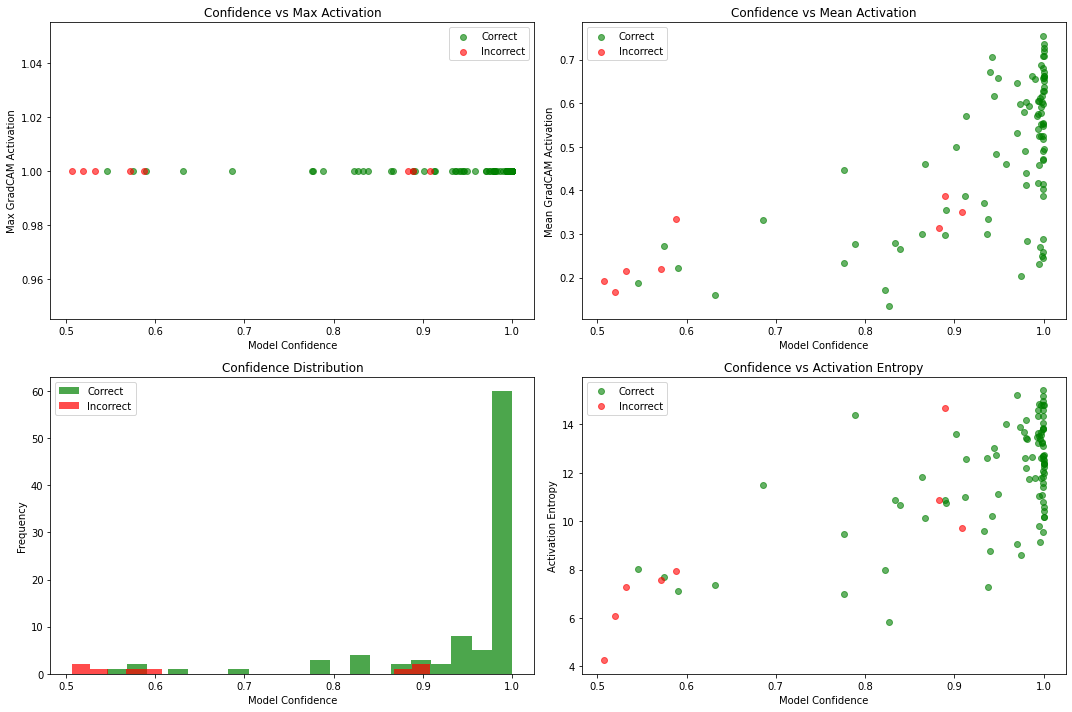

Correlation Analysis:
Confidence vs Max Activation: nan
Confidence vs Mean Activation: 0.631
Confidence vs Entropy: 0.691


/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2559: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/opt/conda/lib/python3.7/site-packages/numpy/lib/function_base.py:2560: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [49]:
gradcam_confidence_analysis(main_classifier, test_dataset, binary_class_names, num_samples=100)

In [50]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image

class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.model.eval()
        self.target_layer_name = target_layer_name
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self._register_hooks()
    
    def _register_hooks(self):
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        
        def forward_hook(module, input, output):
            self.activations = output
        
        # For ResNet-18, the target layer is typically 'layer4'
        target_layer = dict(self.model.named_modules())[self.target_layer_name]
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)
    
    def generate_cam(self, input_image, class_idx=None):
        # Forward pass
        model_output = self.model(input_image)
        
        if class_idx is None:
            class_idx = torch.argmax(model_output, dim=1)
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass
        class_score = model_output[:, class_idx].squeeze()
        class_score.backward(retain_graph=True)
        
        # Get gradients and activations
        gradients = self.gradients
        activations = self.activations
        
        # Pool the gradients across the channels
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        
        # Weight the channels by corresponding gradients
        for i in range(activations.size()[1]):
            activations[:, i, :, :] *= pooled_gradients[i]
        
        # Average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()
        
        # ReLU on top of the heatmap
        heatmap = F.relu(heatmap)
        
        # Normalize the heatmap
        heatmap /= torch.max(heatmap)
        
        return heatmap.detach()

def visualize_gradcam(model, image_tensor, original_image, class_names, target_layer='layer4', 
                     class_idx=None, alpha=0.4, save_path=None):
    """
    Visualize GradCAM for a given image
    
    Args:
        model: Trained PyTorch model
        image_tensor: Preprocessed image tensor (1, 3, 224, 224)
        original_image: Original PIL image for overlay
        class_names: List of class names
        target_layer: Target layer name for GradCAM
        class_idx: Target class index (if None, uses predicted class)
        alpha: Transparency for overlay
        save_path: Path to save the visualization
    """
    # Create GradCAM object
    grad_cam = GradCAM(model, target_layer)
    
    # Generate CAM
    heatmap = grad_cam.generate_cam(image_tensor, class_idx)
    
    # Get prediction
    with torch.no_grad():
        output = model(image_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
        confidence = F.softmax(output, dim=1)[0, predicted_class].item()
    
    # Convert heatmap to numpy
    heatmap_np = heatmap.cpu().numpy()
    
    # Resize heatmap to match original image size
    original_size = original_image.size
    heatmap_resized = cv2.resize(heatmap_np, original_size)
    
    # Convert to RGB
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Convert original image to numpy array
    original_np = np.array(original_image)
    
    # Create overlay
    overlay = heatmap_colored * alpha + original_np * (1 - alpha)
    overlay = np.uint8(overlay)
    
    # Create subplot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Heatmap
    axes[1].imshow(heatmap_resized, cmap='jet')
    axes[1].set_title('GradCAM Heatmap')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(overlay)
    axes[2].set_title(f'Prediction: {class_names[predicted_class]}\nConfidence: {confidence:.3f}')
    axes[2].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return heatmap_np, predicted_class, confidence

def batch_gradcam_analysis(model, dataset, class_names, num_samples=8, target_layer='layer4'):
    """
    Analyze multiple samples with GradCAM
    
    Args:
        model: Trained PyTorch model
        dataset: Dataset object
        class_names: List of class names
        num_samples: Number of samples to analyze
        target_layer: Target layer for GradCAM
    """
    model.eval()
    
    # Get random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))
    
    for i, idx in enumerate(indices):
        # Get image and labels
        image_tensor, binary_label, subclass_label = dataset[idx]
        
        # Add batch dimension
        image_tensor = image_tensor.unsqueeze(0).to(device)
        
        # Get original image for visualization
        original_path = dataset.samples[idx][0]
        original_image = Image.open(original_path).convert('RGB')
        
        # Generate GradCAM
        grad_cam = GradCAM(model, target_layer)
        heatmap = grad_cam.generate_cam(image_tensor)
        
        # Get prediction
        with torch.no_grad():
            output = model(image_tensor)
            predicted_class = torch.argmax(output, dim=1).item()
            confidence = F.softmax(output, dim=1)[0, predicted_class].item()
        
        # Convert heatmap to numpy and resize
        heatmap_np = heatmap.cpu().numpy()
        heatmap_resized = cv2.resize(heatmap_np, original_image.size)
        
        # Create overlay
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        original_np = np.array(original_image)
        overlay = heatmap_colored * 0.4 + original_np * 0.6
        overlay = np.uint8(overlay)
        
        # Plot original image
        axes[0, i].imshow(original_image)
        axes[0, i].set_title(f'True: {class_names[binary_label]}')
        axes[0, i].axis('off')
        
        # Plot GradCAM overlay
        axes[1, i].imshow(overlay)
        axes[1, i].set_title(f'Pred: {class_names[predicted_class]}\nConf: {confidence:.2f}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage examples:

# 1. Load your trained model (uncomment the appropriate line)
# main_classifier.load_state_dict(torch.load('main_classifier_weighted_best.pth'))
# main_classifier.eval()

# 2. Define class names
binary_class_names = ['Benign', 'Malignant']
subtype_class_names = list(label_to_subtype.values())

# 3. Single image GradCAM visualization
def analyze_single_image(model, dataset, idx, class_names, target_layer='layer4'):
    """
    Analyze a single image with GradCAM
    """
    # Get image and labels
    image_tensor, binary_label, subclass_label = dataset[idx]
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    # Get original image
    original_path = dataset.samples[idx][0]
    original_image = Image.open(original_path).convert('RGB')
    
    # Visualize
    heatmap, pred_class, confidence = visualize_gradcam(
        model, image_tensor, original_image, class_names, target_layer
    )
    
    print(f"True label: {class_names[binary_label]}")
    print(f"Predicted: {class_names[pred_class]} (confidence: {confidence:.3f})")
    
    return heatmap, pred_class, confidence

# 4. Compare binary vs subtype classification GradCAMs
def compare_binary_vs_subtype_gradcam(main_model, sub_model, dataset, idx):
    """
    Compare GradCAM visualizations between binary and subtype models
    """
    # Get image and labels
    image_tensor, binary_label, subclass_label = dataset[idx]
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    # Get original image
    original_path = dataset.samples[idx][0]
    original_image = Image.open(original_path).convert('RGB')
    
    # Generate GradCAMs for both models
    grad_cam_main = GradCAM(main_model, 'layer4')
    grad_cam_sub = GradCAM(sub_model, 'layer4')
    
    heatmap_main = grad_cam_main.generate_cam(image_tensor)
    heatmap_sub = grad_cam_sub.generate_cam(image_tensor)
    
    # Get predictions
    with torch.no_grad():
        output_main = main_model(image_tensor)
        output_sub = sub_model(image_tensor)
        
        pred_main = torch.argmax(output_main, dim=1).item()
        pred_sub = torch.argmax(output_sub, dim=1).item()
        
        conf_main = F.softmax(output_main, dim=1)[0, pred_main].item()
        conf_sub = F.softmax(output_sub, dim=1)[0, pred_sub].item()
    
    # Convert heatmaps to numpy
    heatmap_main_np = heatmap_main.cpu().numpy()
    heatmap_sub_np = heatmap_sub.cpu().numpy()
    
    # Resize heatmaps
    heatmap_main_resized = cv2.resize(heatmap_main_np, original_image.size)
    heatmap_sub_resized = cv2.resize(heatmap_sub_np, original_image.size)
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original image
    axes[0, 0].imshow(original_image)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[1, 0].imshow(original_image)
    axes[1, 0].set_title('Original Image')
    axes[1, 0].axis('off')
    
    # Binary model results
    axes[0, 1].imshow(heatmap_main_resized, cmap='jet')
    axes[0, 1].set_title(f'Binary GradCAM\nPred: {binary_class_names[pred_main]}')
    axes[0, 1].axis('off')
    
    # Create overlay for binary
    heatmap_colored_main = cv2.applyColorMap(np.uint8(255 * heatmap_main_resized), cv2.COLORMAP_JET)
    heatmap_colored_main = cv2.cvtColor(heatmap_colored_main, cv2.COLOR_BGR2RGB)
    original_np = np.array(original_image)
    overlay_main = heatmap_colored_main * 0.4 + original_np * 0.6
    overlay_main = np.uint8(overlay_main)
    
    axes[0, 2].imshow(overlay_main)
    axes[0, 2].set_title(f'Binary Overlay\nConf: {conf_main:.3f}')
    axes[0, 2].axis('off')
    
    # Subtype model results
    axes[1, 1].imshow(heatmap_sub_resized, cmap='jet')
    axes[1, 1].set_title(f'Subtype GradCAM\nPred: {subtype_class_names[pred_sub]}')
    axes[1, 1].axis('off')
    
    # Create overlay for subtype
    heatmap_colored_sub = cv2.applyColorMap(np.uint8(255 * heatmap_sub_resized), cv2.COLORMAP_JET)
    heatmap_colored_sub = cv2.cvtColor(heatmap_colored_sub, cv2.COLOR_BGR2RGB)
    overlay_sub = heatmap_colored_sub * 0.4 + original_np * 0.6
    overlay_sub = np.uint8(overlay_sub)
    
    axes[1, 2].imshow(overlay_sub)
    axes[1, 2].set_title(f'Subtype Overlay\nConf: {conf_sub:.3f}')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"True binary label: {binary_class_names[binary_label]}")
    print(f"True subtype: {subtype_class_names[subclass_label]}")

# Additional Verification and Analysis Functions

def verify_gradcam_sanity_check(model, dataset, idx, class_names, target_layer='layer4'):
    """
    Sanity check: GradCAM should change when we modify the target class
    """
    # Get image
    image_tensor, binary_label, subclass_label = dataset[idx]
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    # Get original image
    original_path = dataset.samples[idx][0]
    original_image = Image.open(original_path).convert('RGB')
    
    # Create GradCAM
    grad_cam = GradCAM(model, target_layer)
    
    # Generate CAM for predicted class
    heatmap_pred = grad_cam.generate_cam(image_tensor, class_idx=None)
    
    # Generate CAM for opposite class (0->1, 1->0)
    with torch.no_grad():
        output = model(image_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
    
    opposite_class = 1 - predicted_class
    heatmap_opposite = grad_cam.generate_cam(image_tensor, class_idx=opposite_class)
    
    # Convert to numpy
    heatmap_pred_np = heatmap_pred.cpu().numpy()
    heatmap_opposite_np = heatmap_opposite.cpu().numpy()
    
    # Resize heatmaps
    heatmap_pred_resized = cv2.resize(heatmap_pred_np, original_image.size)
    heatmap_opposite_resized = cv2.resize(heatmap_opposite_np, original_image.size)
    
    # Create visualization
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Original
    axes[0].imshow(original_image)
    axes[0].set_title(f'Original\nTrue: {class_names[binary_label]}')
    axes[0].axis('off')
    
    # Predicted class heatmap
    axes[1].imshow(heatmap_pred_resized, cmap='jet')
    axes[1].set_title(f'GradCAM for Predicted Class\n({class_names[predicted_class]})')
    axes[1].axis('off')
    
    # Opposite class heatmap
    axes[2].imshow(heatmap_opposite_resized, cmap='jet')
    axes[2].set_title(f'GradCAM for Opposite Class\n({class_names[opposite_class]})')
    axes[2].axis('off')
    
    # Difference map
    diff_map = np.abs(heatmap_pred_resized - heatmap_opposite_resized)
    axes[3].imshow(diff_map, cmap='viridis')
    axes[3].set_title('Difference Map\n(Should show distinct patterns)')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation (should be low for good GradCAM)
    correlation = np.corrcoef(heatmap_pred_resized.flatten(), heatmap_opposite_resized.flatten())[0, 1]
    print(f"Correlation between heatmaps: {correlation:.3f}")
    print("Good GradCAM should have low correlation (< 0.5) between different classes")

def analyze_gradcam_statistics(model, dataset, class_names, num_samples=50, target_layer='layer4'):
    """
    Statistical analysis of GradCAM activations across multiple samples
    """
    model.eval()
    grad_cam = GradCAM(model, target_layer)
    
    benign_activations = []
    malignant_activations = []
    
    # Randomly sample images
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    print("Analyzing GradCAM statistics...")
    for idx in tqdm(indices):
        image_tensor, binary_label, _ = dataset[idx]
        image_tensor = image_tensor.unsqueeze(0).to(device)
        
        # Generate heatmap
        heatmap = grad_cam.generate_cam(image_tensor)
        heatmap_np = heatmap.cpu().numpy()
        
        # Calculate statistics
        mean_activation = np.mean(heatmap_np)
        max_activation = np.max(heatmap_np)
        std_activation = np.std(heatmap_np)
        
        stats = {
            'mean': mean_activation,
            'max': max_activation,
            'std': std_activation,
            'sparsity': np.sum(heatmap_np > 0.5) / heatmap_np.size  # Proportion of high activations
        }
        
        if binary_label == 0:  # Benign
            benign_activations.append(stats)
        else:  # Malignant
            malignant_activations.append(stats)
    
    # Convert to DataFrames
    benign_df = pd.DataFrame(benign_activations)
    malignant_df = pd.DataFrame(malignant_activations)
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    metrics = ['mean', 'max', 'std', 'sparsity']
    titles = ['Mean Activation', 'Max Activation', 'Std Activation', 'Activation Sparsity']
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[i//2, i%2]
        
        # Plot distributions
        ax.hist(benign_df[metric], alpha=0.7, label='Benign', bins=15, color='blue')
        ax.hist(malignant_df[metric], alpha=0.7, label='Malignant', bins=15, color='red')
        
        ax.set_title(f'{title} Distribution')
        ax.set_xlabel(metric)
        ax.set_ylabel('Frequency')
        ax.legend()
        
        # Add statistical test
        from scipy.stats import ttest_ind
        t_stat, p_value = ttest_ind(benign_df[metric], malignant_df[metric])
        ax.text(0.02, 0.98, f'p-value: {p_value:.4f}', transform=ax.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nGradCAM Statistics Summary:")
    print("-" * 50)
    print("BENIGN:")
    print(benign_df.describe())
    print("\nMALIGNANT:")
    print(malignant_df.describe())

def visualize_layer_comparison(model, dataset, idx, class_names):
    """
    Compare GradCAM across different ResNet layers
    """
    # ResNet-18 layer names
    layers = ['layer1', 'layer2', 'layer3', 'layer4']
    
    # Get image
    image_tensor, binary_label, _ = dataset[idx]
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    # Get original image
    original_path = dataset.samples[idx][0]
    original_image = Image.open(original_path).convert('RGB')
    
    # Get prediction
    with torch.no_grad():
        output = model(image_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
        confidence = F.softmax(output, dim=1)[0, predicted_class].item()
    
    # Create subplots
    fig, axes = plt.subplots(1, len(layers) + 1, figsize=(20, 4))
    
    # Original image
    axes[0].imshow(original_image)
    axes[0].set_title(f'Original\nTrue: {class_names[binary_label]}\nPred: {class_names[predicted_class]} ({confidence:.2f})')
    axes[0].axis('off')
    
    # Generate GradCAM for each layer
    for i, layer in enumerate(layers):
        grad_cam = GradCAM(model, layer)
        heatmap = grad_cam.generate_cam(image_tensor)
        heatmap_np = heatmap.cpu().numpy()
        heatmap_resized = cv2.resize(heatmap_np, original_image.size)
        
        axes[i+1].imshow(heatmap_resized, cmap='jet')
        axes[i+1].set_title(f'{layer}\nResolution: {heatmap_np.shape}')
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("Layer Comparison:")
    print("- Earlier layers (layer1, layer2) show low-level features")
    print("- Later layers (layer3, layer4) show high-level semantic features")
    print("- layer4 typically provides the best class-discriminative visualizations")

def gradcam_confidence_analysis(model, dataset, class_names, num_samples=100, target_layer='layer4'):
    """
    Analyze relationship between model confidence and GradCAM activation patterns
    """
    model.eval()
    grad_cam = GradCAM(model, target_layer)
    
    results = []
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    print("Analyzing confidence vs GradCAM patterns...")
    for idx in tqdm(indices):
        image_tensor, binary_label, _ = dataset[idx]
        image_tensor = image_tensor.unsqueeze(0).to(device)
        
        # Get prediction and confidence
        with torch.no_grad():
            output = model(image_tensor)
            predicted_class = torch.argmax(output, dim=1).item()
            confidence = F.softmax(output, dim=1)[0, predicted_class].item()
        
        # Generate heatmap
        heatmap = grad_cam.generate_cam(image_tensor)
        heatmap_np = heatmap.cpu().numpy()
        
        # Calculate heatmap metrics
        max_activation = np.max(heatmap_np)
        mean_activation = np.mean(heatmap_np)
        activation_entropy = -np.sum(heatmap_np * np.log(heatmap_np + 1e-10))  # Entropy measure
        
        results.append({
            'confidence': confidence,
            'max_activation': max_activation,
            'mean_activation': mean_activation,
            'entropy': activation_entropy,
            'correct': predicted_class == binary_label
        })
    
    results_df = pd.DataFrame(results)
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Confidence vs Max Activation
    correct = results_df[results_df['correct'] == True]
    incorrect = results_df[results_df['correct'] == False]
    
    axes[0, 0].scatter(correct['confidence'], correct['max_activation'], 
                      alpha=0.6, label='Correct', color='green')
    axes[0, 0].scatter(incorrect['confidence'], incorrect['max_activation'], 
                      alpha=0.6, label='Incorrect', color='red')
    axes[0, 0].set_xlabel('Model Confidence')
    axes[0, 0].set_ylabel('Max GradCAM Activation')
    axes[0, 0].set_title('Confidence vs Max Activation')
    axes[0, 0].legend()
    
    # Confidence vs Mean Activation
    axes[0, 1].scatter(correct['confidence'], correct['mean_activation'], 
                      alpha=0.6, label='Correct', color='green')
    axes[0, 1].scatter(incorrect['confidence'], incorrect['mean_activation'], 
                      alpha=0.6, label='Incorrect', color='red')
    axes[0, 1].set_xlabel('Model Confidence')
    axes[0, 1].set_ylabel('Mean GradCAM Activation')
    axes[0, 1].set_title('Confidence vs Mean Activation')
    axes[0, 1].legend()
    
    # Confidence distribution
    axes[1, 0].hist(correct['confidence'], alpha=0.7, label='Correct', bins=20, color='green')
    axes[1, 0].hist(incorrect['confidence'], alpha=0.7, label='Incorrect', bins=20, color='red')
    axes[1, 0].set_xlabel('Model Confidence')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Confidence Distribution')
    axes[1, 0].legend()
    
    # Activation entropy vs confidence
    axes[1, 1].scatter(correct['confidence'], correct['entropy'], 
                      alpha=0.6, label='Correct', color='green')
    axes[1, 1].scatter(incorrect['confidence'], incorrect['entropy'], 
                      alpha=0.6, label='Incorrect', color='red')
    axes[1, 1].set_xlabel('Model Confidence')
    axes[1, 1].set_ylabel('Activation Entropy')
    axes[1, 1].set_title('Confidence vs Activation Entropy')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print correlation analysis with diagnostics
    print("Correlation Analysis:")
    
    # Check for issues with max activation
    max_act_stats = results_df['max_activation'].describe()
    print(f"\nMax Activation Statistics:")
    print(f"  Min: {max_act_stats['min']:.6f}")
    print(f"  Max: {max_act_stats['max']:.6f}")
    print(f"  Mean: {max_act_stats['mean']:.6f}")
    print(f"  Std: {max_act_stats['std']:.6f}")
    print(f"  Unique values: {results_df['max_activation'].nunique()}")
    
    # Safe correlation calculation
    def safe_correlation(x, y, name):
        try:
            if np.std(x) == 0 or np.std(y) == 0:
                return f"{name}: undefined (zero variance)"
            corr = np.corrcoef(x, y)[0,1]
            if np.isnan(corr):
                return f"{name}: nan (check for constant values)"
            return f"{name}: {corr:.3f}"
        except:
            return f"{name}: error in calculation"
    
    print(f"\nCorrelations:")
    print(safe_correlation(results_df['confidence'], results_df['max_activation'], 
                          "Confidence vs Max Activation"))
    print(safe_correlation(results_df['confidence'], results_df['mean_activation'], 
                          "Confidence vs Mean Activation"))
    print(safe_correlation(results_df['confidence'], results_df['entropy'], 
                          "Confidence vs Entropy"))

# Example usage for verification:
print("Additional GradCAM Verification Functions Added!")
print("\nUsage examples:")
print("1. verify_gradcam_sanity_check(main_classifier, test_dataset, 0, binary_class_names)")
print("2. analyze_gradcam_statistics(main_classifier, test_dataset, binary_class_names)")
print("3. visualize_layer_comparison(main_classifier, test_dataset, 0, binary_class_names)")
print("4. gradcam_confidence_analysis(main_classifier, test_dataset, binary_class_names)")

# Example usage (uncomment to use):
# analyze_single_image(main_classifier, test_dataset, 0, binary_class_names)
# batch_gradcam_analysis(main_classifier, test_dataset, binary_class_names, num_samples=6)
# compare_binary_vs_subtype_gradcam(main_classifier, sub_classifier, test_dataset, 0)

Additional GradCAM Verification Functions Added!

Usage examples:
1. verify_gradcam_sanity_check(main_classifier, test_dataset, 0, binary_class_names)
2. analyze_gradcam_statistics(main_classifier, test_dataset, binary_class_names)
3. visualize_layer_comparison(main_classifier, test_dataset, 0, binary_class_names)
4. gradcam_confidence_analysis(main_classifier, test_dataset, binary_class_names)


In [51]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
from PIL import Image

class GradCAM:
    def __init__(self, model, target_layer_name):
        self.model = model
        self.model.eval()
        self.target_layer_name = target_layer_name
        self.gradients = None
        self.activations = None
        
        # Register hooks
        self._register_hooks()
    
    def _register_hooks(self):
        def backward_hook(module, grad_input, grad_output):
            self.gradients = grad_output[0]
        
        def forward_hook(module, input, output):
            self.activations = output
        
        # For ResNet-18, the target layer is typically 'layer4'
        target_layer = dict(self.model.named_modules())[self.target_layer_name]
        target_layer.register_forward_hook(forward_hook)
        target_layer.register_backward_hook(backward_hook)
    
    def generate_cam(self, input_image, class_idx=None):
        # Forward pass
        model_output = self.model(input_image)
        
        if class_idx is None:
            class_idx = torch.argmax(model_output, dim=1)
        
        # Zero gradients
        self.model.zero_grad()
        
        # Backward pass
        class_score = model_output[:, class_idx].squeeze()
        class_score.backward(retain_graph=True)
        
        # Get gradients and activations
        gradients = self.gradients
        activations = self.activations
        
        # Pool the gradients across the channels
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        
        # Weight the channels by corresponding gradients
        for i in range(activations.size()[1]):
            activations[:, i, :, :] *= pooled_gradients[i]
        
        # Average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()
        
        # ReLU on top of the heatmap
        heatmap = F.relu(heatmap)
        
        # Normalize the heatmap
        heatmap /= torch.max(heatmap)
        
        return heatmap.detach()

def visualize_gradcam(model, image_tensor, original_image, class_names, target_layer='layer4', 
                     class_idx=None, alpha=0.4, save_path=None):
    """
    Visualize GradCAM for a given image
    
    Args:
        model: Trained PyTorch model
        image_tensor: Preprocessed image tensor (1, 3, 224, 224)
        original_image: Original PIL image for overlay
        class_names: List of class names
        target_layer: Target layer name for GradCAM
        class_idx: Target class index (if None, uses predicted class)
        alpha: Transparency for overlay
        save_path: Path to save the visualization
    """
    # Create GradCAM object
    grad_cam = GradCAM(model, target_layer)
    
    # Generate CAM
    heatmap = grad_cam.generate_cam(image_tensor, class_idx)
    
    # Get prediction
    with torch.no_grad():
        output = model(image_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
        confidence = F.softmax(output, dim=1)[0, predicted_class].item()
    
    # Convert heatmap to numpy
    heatmap_np = heatmap.cpu().numpy()
    
    # Resize heatmap to match original image size
    original_size = original_image.size
    heatmap_resized = cv2.resize(heatmap_np, original_size)
    
    # Convert to RGB
    heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
    heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
    
    # Convert original image to numpy array
    original_np = np.array(original_image)
    
    # Create overlay
    overlay = heatmap_colored * alpha + original_np * (1 - alpha)
    overlay = np.uint8(overlay)
    
    # Create subplot
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    axes[0].imshow(original_image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    # Heatmap
    axes[1].imshow(heatmap_resized, cmap='jet')
    axes[1].set_title('GradCAM Heatmap')
    axes[1].axis('off')
    
    # Overlay
    axes[2].imshow(overlay)
    axes[2].set_title(f'Prediction: {class_names[predicted_class]}\nConfidence: {confidence:.3f}')
    axes[2].axis('off')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()
    
    return heatmap_np, predicted_class, confidence

def batch_gradcam_analysis(model, dataset, class_names, num_samples=8, target_layer='layer4'):
    """
    Analyze multiple samples with GradCAM
    
    Args:
        model: Trained PyTorch model
        dataset: Dataset object
        class_names: List of class names
        num_samples: Number of samples to analyze
        target_layer: Target layer for GradCAM
    """
    model.eval()
    
    # Get random samples
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 8))
    
    for i, idx in enumerate(indices):
        # Get image and labels
        image_tensor, binary_label, subclass_label = dataset[idx]
        
        # Add batch dimension
        image_tensor = image_tensor.unsqueeze(0).to(device)
        
        # Get original image for visualization
        original_path = dataset.samples[idx][0]
        original_image = Image.open(original_path).convert('RGB')
        
        # Generate GradCAM
        grad_cam = GradCAM(model, target_layer)
        heatmap = grad_cam.generate_cam(image_tensor)
        
        # Get prediction
        with torch.no_grad():
            output = model(image_tensor)
            predicted_class = torch.argmax(output, dim=1).item()
            confidence = F.softmax(output, dim=1)[0, predicted_class].item()
        
        # Convert heatmap to numpy and resize
        heatmap_np = heatmap.cpu().numpy()
        heatmap_resized = cv2.resize(heatmap_np, original_image.size)
        
        # Create overlay
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmap_resized), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        original_np = np.array(original_image)
        overlay = heatmap_colored * 0.4 + original_np * 0.6
        overlay = np.uint8(overlay)
        
        # Plot original image
        axes[0, i].imshow(original_image)
        axes[0, i].set_title(f'True: {class_names[binary_label]}')
        axes[0, i].axis('off')
        
        # Plot GradCAM overlay
        axes[1, i].imshow(overlay)
        axes[1, i].set_title(f'Pred: {class_names[predicted_class]}\nConf: {confidence:.2f}')
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Usage examples:

# 1. Load your trained model (uncomment the appropriate line)
# main_classifier.load_state_dict(torch.load('main_classifier_weighted_best.pth'))
# main_classifier.eval()

# 2. Define class names
binary_class_names = ['Benign', 'Malignant']
subtype_class_names = list(label_to_subtype.values())

# 3. Single image GradCAM visualization
def analyze_single_image(model, dataset, idx, class_names, target_layer='layer4'):
    """
    Analyze a single image with GradCAM
    """
    # Get image and labels
    image_tensor, binary_label, subclass_label = dataset[idx]
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    # Get original image
    original_path = dataset.samples[idx][0]
    original_image = Image.open(original_path).convert('RGB')
    
    # Visualize
    heatmap, pred_class, confidence = visualize_gradcam(
        model, image_tensor, original_image, class_names, target_layer
    )
    
    print(f"True label: {class_names[binary_label]}")
    print(f"Predicted: {class_names[pred_class]} (confidence: {confidence:.3f})")
    
    return heatmap, pred_class, confidence

# 4. Compare binary vs subtype classification GradCAMs
def compare_binary_vs_subtype_gradcam(main_model, sub_model, dataset, idx):
    """
    Compare GradCAM visualizations between binary and subtype models
    """
    # Get image and labels
    image_tensor, binary_label, subclass_label = dataset[idx]
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    # Get original image
    original_path = dataset.samples[idx][0]
    original_image = Image.open(original_path).convert('RGB')
    
    # Generate GradCAMs for both models
    grad_cam_main = GradCAM(main_model, 'layer4')
    grad_cam_sub = GradCAM(sub_model, 'layer4')
    
    heatmap_main = grad_cam_main.generate_cam(image_tensor)
    heatmap_sub = grad_cam_sub.generate_cam(image_tensor)
    
    # Get predictions
    with torch.no_grad():
        output_main = main_model(image_tensor)
        output_sub = sub_model(image_tensor)
        
        pred_main = torch.argmax(output_main, dim=1).item()
        pred_sub = torch.argmax(output_sub, dim=1).item()
        
        conf_main = F.softmax(output_main, dim=1)[0, pred_main].item()
        conf_sub = F.softmax(output_sub, dim=1)[0, pred_sub].item()
    
    # Convert heatmaps to numpy
    heatmap_main_np = heatmap_main.cpu().numpy()
    heatmap_sub_np = heatmap_sub.cpu().numpy()
    
    # Resize heatmaps
    heatmap_main_resized = cv2.resize(heatmap_main_np, original_image.size)
    heatmap_sub_resized = cv2.resize(heatmap_sub_np, original_image.size)
    
    # Create visualization
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original image
    axes[0, 0].imshow(original_image)
    axes[0, 0].set_title('Original Image')
    axes[0, 0].axis('off')
    
    axes[1, 0].imshow(original_image)
    axes[1, 0].set_title('Original Image')
    axes[1, 0].axis('off')
    
    # Binary model results
    axes[0, 1].imshow(heatmap_main_resized, cmap='jet')
    axes[0, 1].set_title(f'Binary GradCAM\nPred: {binary_class_names[pred_main]}')
    axes[0, 1].axis('off')
    
    # Create overlay for binary
    heatmap_colored_main = cv2.applyColorMap(np.uint8(255 * heatmap_main_resized), cv2.COLORMAP_JET)
    heatmap_colored_main = cv2.cvtColor(heatmap_colored_main, cv2.COLOR_BGR2RGB)
    original_np = np.array(original_image)
    overlay_main = heatmap_colored_main * 0.4 + original_np * 0.6
    overlay_main = np.uint8(overlay_main)
    
    axes[0, 2].imshow(overlay_main)
    axes[0, 2].set_title(f'Binary Overlay\nConf: {conf_main:.3f}')
    axes[0, 2].axis('off')
    
    # Subtype model results
    axes[1, 1].imshow(heatmap_sub_resized, cmap='jet')
    axes[1, 1].set_title(f'Subtype GradCAM\nPred: {subtype_class_names[pred_sub]}')
    axes[1, 1].axis('off')
    
    # Create overlay for subtype
    heatmap_colored_sub = cv2.applyColorMap(np.uint8(255 * heatmap_sub_resized), cv2.COLORMAP_JET)
    heatmap_colored_sub = cv2.cvtColor(heatmap_colored_sub, cv2.COLOR_BGR2RGB)
    overlay_sub = heatmap_colored_sub * 0.4 + original_np * 0.6
    overlay_sub = np.uint8(overlay_sub)
    
    axes[1, 2].imshow(overlay_sub)
    axes[1, 2].set_title(f'Subtype Overlay\nConf: {conf_sub:.3f}')
    axes[1, 2].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print(f"True binary label: {binary_class_names[binary_label]}")
    print(f"True subtype: {subtype_class_names[subclass_label]}")

# Additional Verification and Analysis Functions

def verify_gradcam_sanity_check(model, dataset, idx, class_names, target_layer='layer4'):
    """
    Sanity check: GradCAM should change when we modify the target class
    """
    # Get image
    image_tensor, binary_label, subclass_label = dataset[idx]
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    # Get original image
    original_path = dataset.samples[idx][0]
    original_image = Image.open(original_path).convert('RGB')
    
    # Create GradCAM
    grad_cam = GradCAM(model, target_layer)
    
    # Generate CAM for predicted class
    heatmap_pred = grad_cam.generate_cam(image_tensor, class_idx=None)
    
    # Generate CAM for opposite class (0->1, 1->0)
    with torch.no_grad():
        output = model(image_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
    
    opposite_class = 1 - predicted_class
    heatmap_opposite = grad_cam.generate_cam(image_tensor, class_idx=opposite_class)
    
    # Convert to numpy
    heatmap_pred_np = heatmap_pred.cpu().numpy()
    heatmap_opposite_np = heatmap_opposite.cpu().numpy()
    
    # Resize heatmaps
    heatmap_pred_resized = cv2.resize(heatmap_pred_np, original_image.size)
    heatmap_opposite_resized = cv2.resize(heatmap_opposite_np, original_image.size)
    
    # Create visualization
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    
    # Original
    axes[0].imshow(original_image)
    axes[0].set_title(f'Original\nTrue: {class_names[binary_label]}')
    axes[0].axis('off')
    
    # Predicted class heatmap
    axes[1].imshow(heatmap_pred_resized, cmap='jet')
    axes[1].set_title(f'GradCAM for Predicted Class\n({class_names[predicted_class]})')
    axes[1].axis('off')
    
    # Opposite class heatmap
    axes[2].imshow(heatmap_opposite_resized, cmap='jet')
    axes[2].set_title(f'GradCAM for Opposite Class\n({class_names[opposite_class]})')
    axes[2].axis('off')
    
    # Difference map
    diff_map = np.abs(heatmap_pred_resized - heatmap_opposite_resized)
    axes[3].imshow(diff_map, cmap='viridis')
    axes[3].set_title('Difference Map\n(Should show distinct patterns)')
    axes[3].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate correlation (should be low for good GradCAM)
    correlation = np.corrcoef(heatmap_pred_resized.flatten(), heatmap_opposite_resized.flatten())[0, 1]
    print(f"Correlation between heatmaps: {correlation:.3f}")
    print("Good GradCAM should have low correlation (< 0.5) between different classes")

def analyze_gradcam_statistics(model, dataset, class_names, num_samples=50, target_layer='layer4'):
    """
    Statistical analysis of GradCAM activations across multiple samples
    """
    model.eval()
    grad_cam = GradCAM(model, target_layer)
    
    benign_activations = []
    malignant_activations = []
    
    # Randomly sample images
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    print("Analyzing GradCAM statistics...")
    for idx in tqdm(indices):
        image_tensor, binary_label, _ = dataset[idx]
        image_tensor = image_tensor.unsqueeze(0).to(device)
        
        # Generate heatmap
        heatmap = grad_cam.generate_cam(image_tensor)
        heatmap_np = heatmap.cpu().numpy()
        
        # Calculate statistics
        mean_activation = np.mean(heatmap_np)
        max_activation = np.max(heatmap_np)
        std_activation = np.std(heatmap_np)
        
        stats = {
            'mean': mean_activation,
            'max': max_activation,
            'std': std_activation,
            'sparsity': np.sum(heatmap_np > 0.5) / heatmap_np.size  # Proportion of high activations
        }
        
        if binary_label == 0:  # Benign
            benign_activations.append(stats)
        else:  # Malignant
            malignant_activations.append(stats)
    
    # Convert to DataFrames
    benign_df = pd.DataFrame(benign_activations)
    malignant_df = pd.DataFrame(malignant_activations)
    
    # Create comparison plots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    metrics = ['mean', 'max', 'std', 'sparsity']
    titles = ['Mean Activation', 'Max Activation', 'Std Activation', 'Activation Sparsity']
    
    for i, (metric, title) in enumerate(zip(metrics, titles)):
        ax = axes[i//2, i%2]
        
        # Plot distributions
        ax.hist(benign_df[metric], alpha=0.7, label='Benign', bins=15, color='blue')
        ax.hist(malignant_df[metric], alpha=0.7, label='Malignant', bins=15, color='red')
        
        ax.set_title(f'{title} Distribution')
        ax.set_xlabel(metric)
        ax.set_ylabel('Frequency')
        ax.legend()
        
        # Add statistical test
        from scipy.stats import ttest_ind
        t_stat, p_value = ttest_ind(benign_df[metric], malignant_df[metric])
        ax.text(0.02, 0.98, f'p-value: {p_value:.4f}', transform=ax.transAxes, 
                verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nGradCAM Statistics Summary:")
    print("-" * 50)
    print("BENIGN:")
    print(benign_df.describe())
    print("\nMALIGNANT:")
    print(malignant_df.describe())

def visualize_layer_comparison(model, dataset, idx, class_names):
    """
    Compare GradCAM across different ResNet layers
    """
    # ResNet-18 layer names
    layers = ['layer1', 'layer2', 'layer3', 'layer4']
    
    # Get image
    image_tensor, binary_label, _ = dataset[idx]
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    # Get original image
    original_path = dataset.samples[idx][0]
    original_image = Image.open(original_path).convert('RGB')
    
    # Get prediction
    with torch.no_grad():
        output = model(image_tensor)
        predicted_class = torch.argmax(output, dim=1).item()
        confidence = F.softmax(output, dim=1)[0, predicted_class].item()
    
    # Create subplots
    fig, axes = plt.subplots(1, len(layers) + 1, figsize=(20, 4))
    
    # Original image
    axes[0].imshow(original_image)
    axes[0].set_title(f'Original\nTrue: {class_names[binary_label]}\nPred: {class_names[predicted_class]} ({confidence:.2f})')
    axes[0].axis('off')
    
    # Generate GradCAM for each layer
    for i, layer in enumerate(layers):
        grad_cam = GradCAM(model, layer)
        heatmap = grad_cam.generate_cam(image_tensor)
        heatmap_np = heatmap.cpu().numpy()
        heatmap_resized = cv2.resize(heatmap_np, original_image.size)
        
        axes[i+1].imshow(heatmap_resized, cmap='jet')
        axes[i+1].set_title(f'{layer}\nResolution: {heatmap_np.shape}')
        axes[i+1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    print("Layer Comparison:")
    print("- Earlier layers (layer1, layer2) show low-level features")
    print("- Later layers (layer3, layer4) show high-level semantic features")
    print("- layer4 typically provides the best class-discriminative visualizations")

def gradcam_confidence_analysis(model, dataset, class_names, num_samples=100, target_layer='layer4'):
    """
    Analyze relationship between model confidence and GradCAM activation patterns
    """
    model.eval()
    grad_cam = GradCAM(model, target_layer)
    
    results = []
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    print("Analyzing confidence vs GradCAM patterns...")
    for idx in tqdm(indices):
        image_tensor, binary_label, _ = dataset[idx]
        image_tensor = image_tensor.unsqueeze(0).to(device)
        
        # Get prediction and confidence
        with torch.no_grad():
            output = model(image_tensor)
            predicted_class = torch.argmax(output, dim=1).item()
            confidence = F.softmax(output, dim=1)[0, predicted_class].item()
        
        # Generate heatmap
        heatmap = grad_cam.generate_cam(image_tensor)
        heatmap_np = heatmap.cpu().numpy()
        
        # Calculate heatmap metrics
        max_activation = np.max(heatmap_np)
        mean_activation = np.mean(heatmap_np)
        activation_entropy = -np.sum(heatmap_np * np.log(heatmap_np + 1e-10))  # Entropy measure
        
        results.append({
            'confidence': confidence,
            'max_activation': max_activation,
            'mean_activation': mean_activation,
            'entropy': activation_entropy,
            'correct': predicted_class == binary_label
        })
    
    results_df = pd.DataFrame(results)
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Confidence vs Max Activation
    correct = results_df[results_df['correct'] == True]
    incorrect = results_df[results_df['correct'] == False]
    
    axes[0, 0].scatter(correct['confidence'], correct['max_activation'], 
                      alpha=0.6, label='Correct', color='green')
    axes[0, 0].scatter(incorrect['confidence'], incorrect['max_activation'], 
                      alpha=0.6, label='Incorrect', color='red')
    axes[0, 0].set_xlabel('Model Confidence')
    axes[0, 0].set_ylabel('Max GradCAM Activation')
    axes[0, 0].set_title('Confidence vs Max Activation')
    axes[0, 0].legend()
    
    # Confidence vs Mean Activation
    axes[0, 1].scatter(correct['confidence'], correct['mean_activation'], 
                      alpha=0.6, label='Correct', color='green')
    axes[0, 1].scatter(incorrect['confidence'], incorrect['mean_activation'], 
                      alpha=0.6, label='Incorrect', color='red')
    axes[0, 1].set_xlabel('Model Confidence')
    axes[0, 1].set_ylabel('Mean GradCAM Activation')
    axes[0, 1].set_title('Confidence vs Mean Activation')
    axes[0, 1].legend()
    
    # Confidence distribution
    axes[1, 0].hist(correct['confidence'], alpha=0.7, label='Correct', bins=20, color='green')
    axes[1, 0].hist(incorrect['confidence'], alpha=0.7, label='Incorrect', bins=20, color='red')
    axes[1, 0].set_xlabel('Model Confidence')
    axes[1, 0].set_ylabel('Frequency')
    axes[1, 0].set_title('Confidence Distribution')
    axes[1, 0].legend()
    
    # Activation entropy vs confidence
    axes[1, 1].scatter(correct['confidence'], correct['entropy'], 
                      alpha=0.6, label='Correct', color='green')
    axes[1, 1].scatter(incorrect['confidence'], incorrect['entropy'], 
                      alpha=0.6, label='Incorrect', color='red')
    axes[1, 1].set_xlabel('Model Confidence')
    axes[1, 1].set_ylabel('Activation Entropy')
    axes[1, 1].set_title('Confidence vs Activation Entropy')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.show()
    
    # Print correlation analysis with diagnostics
    print("Correlation Analysis:")
    
    # Check for issues with max activation
    max_act_stats = results_df['max_activation'].describe()
    print(f"\nMax Activation Statistics:")
    print(f"  Min: {max_act_stats['min']:.6f}")
    print(f"  Max: {max_act_stats['max']:.6f}")
    print(f"  Mean: {max_act_stats['mean']:.6f}")
    print(f"  Std: {max_act_stats['std']:.6f}")
    print(f"  Unique values: {results_df['max_activation'].nunique()}")
    
    # Safe correlation calculation
    def safe_correlation(x, y, name):
        try:
            if np.std(x) == 0 or np.std(y) == 0:
                return f"{name}: undefined (zero variance)"
            corr = np.corrcoef(x, y)[0,1]
            if np.isnan(corr):
                return f"{name}: nan (check for constant values)"
            return f"{name}: {corr:.3f}"
        except:
            return f"{name}: error in calculation"
    
    print(f"\nCorrelations:")
    print(safe_correlation(results_df['confidence'], results_df['max_activation'], 
                          "Confidence vs Max Activation"))
    print(safe_correlation(results_df['confidence'], results_df['mean_activation'], 
                          "Confidence vs Mean Activation"))
    print(safe_correlation(results_df['confidence'], results_df['entropy'], 
                          "Confidence vs Entropy"))

# Example usage for verification:
print("Additional GradCAM Verification Functions Added!")
print("\nUsage examples:")
print("1. verify_gradcam_sanity_check(main_classifier, test_dataset, 0, binary_class_names)")
print("2. analyze_gradcam_statistics(main_classifier, test_dataset, binary_class_names)")
print("3. visualize_layer_comparison(main_classifier, test_dataset, 0, binary_class_names)")
print("4. gradcam_confidence_analysis(main_classifier, test_dataset, binary_class_names)")

# Example usage (uncomment to use):
# analyze_single_image(main_classifier, test_dataset, 0, binary_class_names)
# batch_gradcam_analysis(main_classifier, test_dataset, binary_class_names, num_samples=6)
# compare_binary_vs_subtype_gradcam(main_classifier, sub_classifier, test_dataset, 0)

Additional GradCAM Verification Functions Added!

Usage examples:
1. verify_gradcam_sanity_check(main_classifier, test_dataset, 0, binary_class_names)
2. analyze_gradcam_statistics(main_classifier, test_dataset, binary_class_names)
3. visualize_layer_comparison(main_classifier, test_dataset, 0, binary_class_names)
4. gradcam_confidence_analysis(main_classifier, test_dataset, binary_class_names)


In [53]:
def diagnose_gradcam_activations(model, dataset, num_samples=10, target_layer='layer4'):
    """
    Diagnose potential issues with GradCAM activations
    """
    model.eval()
    grad_cam = GradCAM(model, target_layer)
    
    print("Diagnosing GradCAM Activations...")
    print("-" * 50)
    
    activations_info = []
    
    for i in range(min(num_samples, len(dataset))):
        image_tensor, binary_label, _ = dataset[i]
        image_tensor = image_tensor.unsqueeze(0).to(device)
        
        # Generate heatmap
        heatmap = grad_cam.generate_cam(image_tensor)
        heatmap_np = heatmap.cpu().numpy()
        
        # Get prediction info
        with torch.no_grad():
            output = model(image_tensor)
            confidence = F.softmax(output, dim=1).max().item()
        
        info = {
            'sample': i,
            'shape': heatmap_np.shape,
            'min': np.min(heatmap_np),
            'max': np.max(heatmap_np),
            'mean': np.mean(heatmap_np),
            'std': np.std(heatmap_np),
            'has_nan': np.isnan(heatmap_np).any(),
            'has_inf': np.isinf(heatmap_np).any(),
            'all_zeros': np.all(heatmap_np == 0),
            'confidence': confidence
        }
        
        activations_info.append(info)
        
        print(f"Sample {i}: min={info['min']:.4f}, max={info['max']:.4f}, "
              f"mean={info['mean']:.4f}, std={info['std']:.4f}, conf={info['confidence']:.3f}")
        
        if info['has_nan']:
            print(f"  ⚠️  Sample {i} contains NaN values!")
        if info['has_inf']:
            print(f"  ⚠️  Sample {i} contains Inf values!")
        if info['all_zeros']:
            print(f"  ⚠️  Sample {i} has all zero activations!")
        if info['max'] == info['min']:
            print(f"  ⚠️  Sample {i} has constant activation values!")
    
    # Summary statistics
    all_maxes = [info['max'] for info in activations_info]
    all_means = [info['mean'] for info in activations_info]
    
    print(f"\nSummary:")
    print(f"Max activation range: {min(all_maxes):.4f} to {max(all_maxes):.4f}")
    print(f"Mean activation range: {min(all_means):.4f} to {max(all_means):.4f}")
    print(f"Max activation std: {np.std(all_maxes):.4f}")
    print(f"Mean activation std: {np.std(all_means):.4f}")
    
    if np.std(all_maxes) < 1e-6:
        print("⚠️  WARNING: Max activations have very low variance - this could cause NaN correlations!")
    
    return activations_info

# Now run the diagnostic
diagnose_gradcam_activations(main_classifier, test_dataset, num_samples=10)

Diagnosing GradCAM Activations...
--------------------------------------------------
Sample 0: min=0.0000, max=1.0000, mean=0.1826, std=0.3188, conf=0.525
Sample 1: min=0.0000, max=1.0000, mean=0.4835, std=0.2399, conf=0.945
Sample 2: min=0.3009, max=1.0000, mean=0.5749, std=0.1723, conf=0.993
Sample 3: min=0.0459, max=1.0000, mean=0.3712, std=0.2536, conf=1.000
Sample 4: min=0.3835, max=1.0000, mean=0.6720, std=0.1393, conf=1.000
Sample 5: min=0.2529, max=1.0000, mean=0.5177, std=0.1971, conf=0.999
Sample 6: min=0.3002, max=1.0000, mean=0.6125, std=0.1800, conf=0.996
Sample 7: min=0.0000, max=1.0000, mean=0.3201, std=0.2410, conf=0.996
Sample 8: min=0.1793, max=1.0000, mean=0.5545, std=0.2165, conf=0.999
Sample 9: min=0.0500, max=1.0000, mean=0.5965, std=0.2414, conf=0.991

Summary:
Max activation range: 1.0000 to 1.0000
Mean activation range: 0.1826 to 0.6720
Max activation std: 0.0000
Mean activation std: 0.1446
⚠️  WARNING: Max activations have very low variance - this could cause 

[{'sample': 0,
  'shape': (7, 7),
  'min': 0.0,
  'max': 1.0,
  'mean': 0.1825903,
  'std': 0.3187739,
  'has_nan': False,
  'has_inf': False,
  'all_zeros': False,
  'confidence': 0.5245136022567749},
 {'sample': 1,
  'shape': (7, 7),
  'min': 0.0,
  'max': 1.0,
  'mean': 0.48347723,
  'std': 0.23986164,
  'has_nan': False,
  'has_inf': False,
  'all_zeros': False,
  'confidence': 0.9445609450340271},
 {'sample': 2,
  'shape': (7, 7),
  'min': 0.3008625,
  'max': 1.0,
  'mean': 0.5748548,
  'std': 0.17229518,
  'has_nan': False,
  'has_inf': False,
  'all_zeros': False,
  'confidence': 0.9933605790138245},
 {'sample': 3,
  'shape': (7, 7),
  'min': 0.045855206,
  'max': 1.0,
  'mean': 0.3711531,
  'std': 0.25357637,
  'has_nan': False,
  'has_inf': False,
  'all_zeros': False,
  'confidence': 0.9996957778930664},
 {'sample': 4,
  'shape': (7, 7),
  'min': 0.38346586,
  'max': 1.0,
  'mean': 0.67197704,
  'std': 0.1393173,
  'has_nan': False,
  'has_inf': False,
  'all_zeros': False,
 

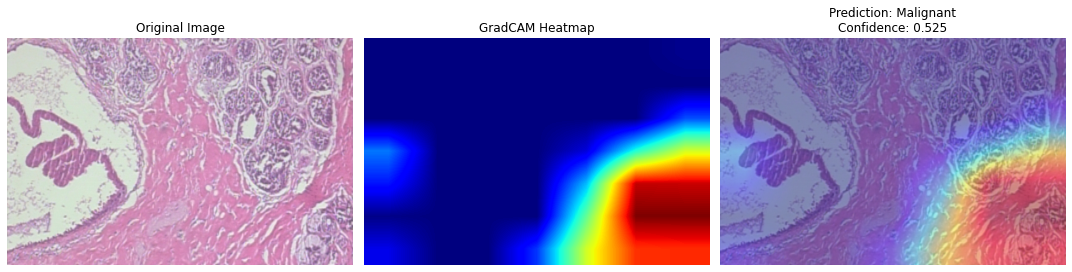

True label: Benign
Predicted: Malignant (confidence: 0.525)


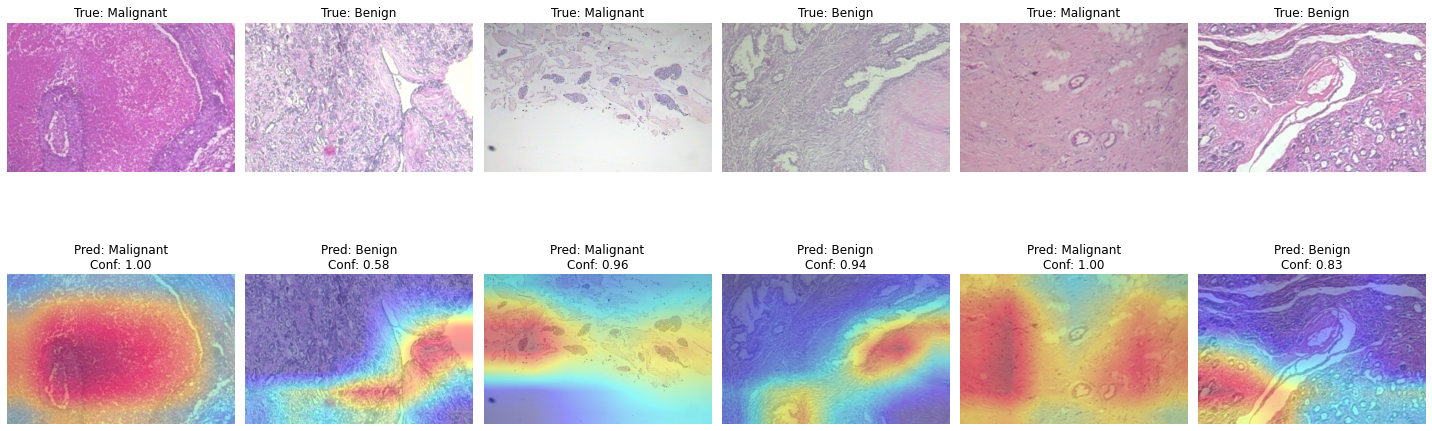

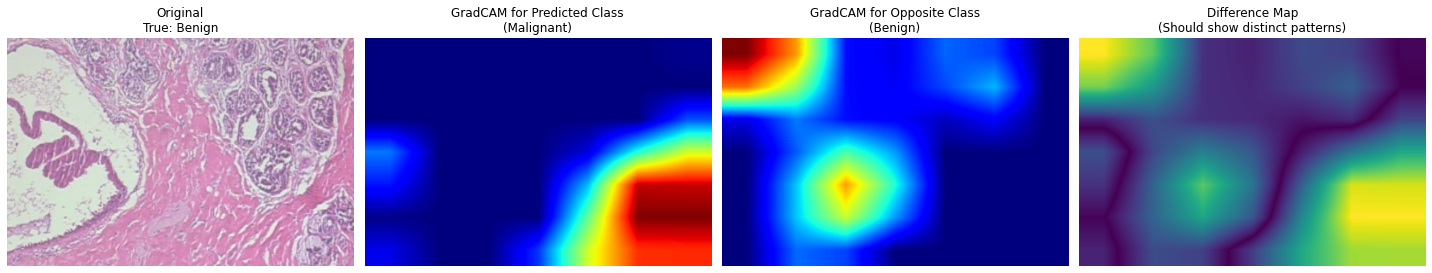

Correlation between heatmaps: -0.486
Good GradCAM should have low correlation (< 0.5) between different classes


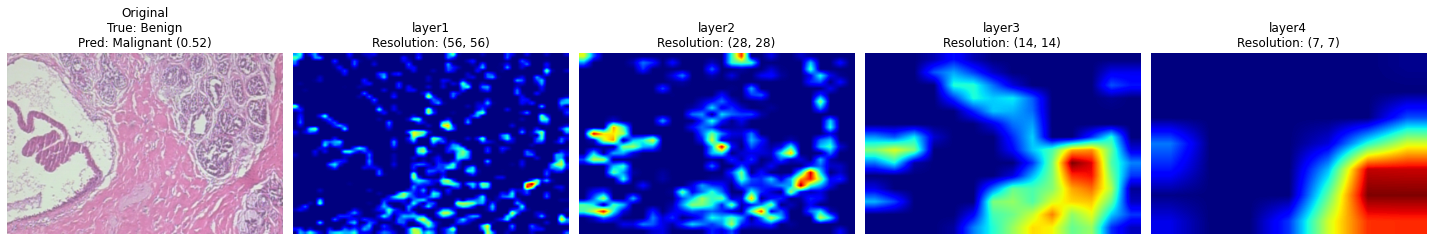

Layer Comparison:
- Earlier layers (layer1, layer2) show low-level features
- Later layers (layer3, layer4) show high-level semantic features
- layer4 typically provides the best class-discriminative visualizations


In [54]:
# 1. Look at some visualizations to see the quality
binary_class_names = ['Benign', 'Malignant']
analyze_single_image(main_classifier, test_dataset, 0, binary_class_names)

# 2. Batch analysis to see patterns
batch_gradcam_analysis(main_classifier, test_dataset, binary_class_names, num_samples=6)

# 3. Sanity check - this is important!
verify_gradcam_sanity_check(main_classifier, test_dataset, 0, binary_class_names)

# 4. Layer comparison to see different levels of features
visualize_layer_comparison(main_classifier, test_dataset, 0, binary_class_names)

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cv2
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import pandas as pd
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

# 1. ATTENTION HEATMAP CLUSTERING ANALYSIS
def gradcam_pattern_clustering(model, dataset, num_samples=100, target_layer='layer4'):
    """
    Cluster samples based on their GradCAM attention patterns
    """
    print("Analyzing GradCAM Pattern Clustering...")
    
    model.eval()
    grad_cam = GradCAM(model, target_layer)
    
    # Collect heatmaps and metadata
    heatmaps = []
    labels = []
    confidences = []
    predictions = []
    
    # Sample indices
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for idx in tqdm(indices, desc="Generating heatmaps"):
        image_tensor, binary_label, _ = dataset[idx]
        image_tensor = image_tensor.unsqueeze(0).to(device)
        
        # Generate heatmap
        heatmap = grad_cam.generate_cam(image_tensor)
        heatmap_flat = heatmap.cpu().numpy().flatten()
        
        # Get prediction
        with torch.no_grad():
            output = model(image_tensor)
            pred_class = torch.argmax(output, dim=1).item()
            confidence = F.softmax(output, dim=1)[0, pred_class].item()
        
        heatmaps.append(heatmap_flat)
        labels.append(binary_label)
        confidences.append(confidence)
        predictions.append(pred_class)
    
    # Convert to arrays
    heatmaps = np.array(heatmaps)
    labels = np.array(labels)
    confidences = np.array(confidences)
    predictions = np.array(predictions)
    
    # Dimensionality reduction
    print("Performing dimensionality reduction...")
    
    # PCA
    pca = PCA(n_components=50)
    heatmaps_pca = pca.fit_transform(heatmaps)
    
    # t-SNE
    tsne = TSNE(n_components=2, random_state=42, perplexity=30)
    heatmaps_tsne = tsne.fit_transform(heatmaps_pca)
    
    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 15))
    
    # t-SNE plot colored by true labels
    ax1 = plt.subplot(2, 3, 1)
    scatter1 = ax1.scatter(heatmaps_tsne[:, 0], heatmaps_tsne[:, 1], 
                          c=labels, cmap='RdYlBu', alpha=0.7, s=50)
    ax1.set_title('t-SNE: GradCAM Patterns by True Labels\n(Blue=Benign, Red=Malignant)')
    ax1.set_xlabel('t-SNE 1')
    ax1.set_ylabel('t-SNE 2')
    plt.colorbar(scatter1, ax=ax1)
    
    # t-SNE plot colored by predictions
    ax2 = plt.subplot(2, 3, 2)
    scatter2 = ax2.scatter(heatmaps_tsne[:, 0], heatmaps_tsne[:, 1], 
                          c=predictions, cmap='RdYlBu', alpha=0.7, s=50)
    ax2.set_title('t-SNE: GradCAM Patterns by Predictions')
    ax2.set_xlabel('t-SNE 1')
    ax2.set_ylabel('t-SNE 2')
    plt.colorbar(scatter2, ax=ax2)
    
    # t-SNE plot colored by confidence
    ax3 = plt.subplot(2, 3, 3)
    scatter3 = ax3.scatter(heatmaps_tsne[:, 0], heatmaps_tsne[:, 1], 
                          c=confidences, cmap='viridis', alpha=0.7, s=50)
    ax3.set_title('t-SNE: GradCAM Patterns by Model Confidence')
    ax3.set_xlabel('t-SNE 1')
    ax3.set_ylabel('t-SNE 2')
    plt.colorbar(scatter3, ax=ax3)
    
    # Hierarchical clustering of attention patterns
    ax4 = plt.subplot(2, 3, 4)
    distances = pdist(heatmaps[:50], metric='cosine')  # Use subset for speed
    linkage_matrix = linkage(distances, method='ward')
    dendrogram(linkage_matrix, ax=ax4, leaf_rotation=90)
    ax4.set_title('Hierarchical Clustering of Attention Patterns\n(First 50 samples)')
    ax4.set_xlabel('Sample Index')
    ax4.set_ylabel('Distance')
    
    # PCA explained variance
    ax5 = plt.subplot(2, 3, 5)
    cumsum_var = np.cumsum(pca.explained_variance_ratio_)
    ax5.plot(range(1, len(cumsum_var)+1), cumsum_var, 'bo-')
    ax5.axhline(y=0.95, color='r', linestyle='--', label='95% variance')
    ax5.set_title('PCA: Cumulative Explained Variance')
    ax5.set_xlabel('Number of Components')
    ax5.set_ylabel('Cumulative Explained Variance')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Attention pattern similarity matrix
    ax6 = plt.subplot(2, 3, 6)
    similarity_matrix = 1 - squareform(pdist(heatmaps[:30], metric='cosine'))
    im = ax6.imshow(similarity_matrix, cmap='coolwarm', aspect='auto')
    ax6.set_title('Attention Pattern Similarity Matrix\n(First 30 samples)')
    ax6.set_xlabel('Sample Index')
    ax6.set_ylabel('Sample Index')
    plt.colorbar(im, ax=ax6)
    
    plt.tight_layout()
    plt.show()
    
    return heatmaps_tsne, labels, confidences, predictions

# 2. MULTI-SCALE GRADCAM ANALYSIS
def multi_scale_gradcam_analysis(model, dataset, idx, class_names):
    """
    Advanced multi-scale GradCAM analysis with statistical overlays
    """
    # Get image and prediction
    image_tensor, binary_label, _ = dataset[idx]
    image_tensor = image_tensor.unsqueeze(0).to(device)
    
    original_path = dataset.samples[idx][0]
    original_image = Image.open(original_path).convert('RGB')
    original_np = np.array(original_image)
    
    # Get prediction
    with torch.no_grad():
        output = model(image_tensor)
        pred_class = torch.argmax(output, dim=1).item()
        confidence = F.softmax(output, dim=1)[0, pred_class].item()
        class_probs = F.softmax(output, dim=1)[0].cpu().numpy()
    
    # Generate multi-layer GradCAMs
    layers = ['layer1', 'layer2', 'layer3', 'layer4']
    heatmaps = {}
    
    for layer in layers:
        grad_cam = GradCAM(model, layer)
        heatmap = grad_cam.generate_cam(image_tensor)
        heatmaps[layer] = cv2.resize(heatmap.cpu().numpy(), original_image.size)
    
    # Create advanced visualization
    fig = plt.figure(figsize=(25, 20))
    
    # Original image with prediction info
    ax1 = plt.subplot(4, 5, 1)
    ax1.imshow(original_image)
    ax1.set_title(f'Original Image\nTrue: {class_names[binary_label]}\nPred: {class_names[pred_class]}\nConf: {confidence:.3f}', 
                  fontsize=12, fontweight='bold')
    ax1.axis('off')
    
    # Individual layer heatmaps
    for i, layer in enumerate(layers):
        ax = plt.subplot(4, 5, i+2)
        im = ax.imshow(heatmaps[layer], cmap='jet', alpha=0.8)
        ax.set_title(f'{layer} Heatmap\nResolution: {heatmaps[layer].shape}')
        ax.axis('off')
        plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    
    # Layer overlays on original image
    for i, layer in enumerate(layers):
        ax = plt.subplot(4, 5, i+6)
        
        # Create colored heatmap
        heatmap_colored = cv2.applyColorMap(np.uint8(255 * heatmaps[layer]), cv2.COLORMAP_JET)
        heatmap_colored = cv2.cvtColor(heatmap_colored, cv2.COLOR_BGR2RGB)
        
        # Overlay
        overlay = heatmap_colored * 0.4 + original_np * 0.6
        overlay = np.uint8(overlay)
        
        ax.imshow(overlay)
        ax.set_title(f'{layer} Overlay')
        ax.axis('off')
    
    # Combined multi-scale heatmap (weighted average)
    ax10 = plt.subplot(4, 5, 10)
    weights = [0.1, 0.2, 0.3, 0.4]  # Give more weight to later layers
    combined_heatmap = np.zeros_like(heatmaps['layer4'])
    for i, layer in enumerate(layers):
        combined_heatmap += weights[i] * heatmaps[layer]
    
    combined_heatmap /= np.max(combined_heatmap)
    im10 = ax10.imshow(combined_heatmap, cmap='jet')
    ax10.set_title('Multi-Scale Combined\nHeatmap')
    ax10.axis('off')
    plt.colorbar(im10, ax=ax10, fraction=0.046, pad=0.04)
    
    # Statistical analysis plots
    ax11 = plt.subplot(4, 5, 11)
    layer_means = [np.mean(heatmaps[layer]) for layer in layers]
    layer_stds = [np.std(heatmaps[layer]) for layer in layers]
    
    x_pos = np.arange(len(layers))
    bars = ax11.bar(x_pos, layer_means, yerr=layer_stds, capsize=5, 
                    color=['lightblue', 'lightgreen', 'orange', 'lightcoral'])
    ax11.set_xlabel('Layer')
    ax11.set_ylabel('Mean Activation')
    ax11.set_title('Layer-wise Activation Statistics')
    ax11.set_xticks(x_pos)
    ax11.set_xticklabels(layers, rotation=45)
    ax11.grid(True, alpha=0.3)
    
    # Class probability distribution
    ax12 = plt.subplot(4, 5, 12)
    bars = ax12.bar(class_names, class_probs, color=['skyblue', 'lightcoral'])
    ax12.set_ylabel('Probability')
    ax12.set_title('Class Probabilities')
    ax12.set_ylim(0, 1)
    
    # Add probability values on bars
    for bar, prob in zip(bars, class_probs):
        height = bar.get_height()
        ax12.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                 f'{prob:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Attention focus analysis
    ax13 = plt.subplot(4, 5, 13)
    
    # Calculate attention entropy for each layer
    entropies = []
    for layer in layers:
        hmap = heatmaps[layer].flatten()
        hmap = hmap / np.sum(hmap)  # Normalize
        entropy = -np.sum(hmap * np.log(hmap + 1e-10))
        entropies.append(entropy)
    
    ax13.plot(layers, entropies, 'o-', color='purple', linewidth=2, markersize=8)
    ax13.set_ylabel('Attention Entropy')
    ax13.set_title('Attention Focus vs Layer Depth\n(Lower = More Focused)')
    ax13.grid(True, alpha=0.3)
    ax13.tick_params(axis='x', rotation=45)
    
    # Activation distribution histogram
    ax14 = plt.subplot(4, 5, 14)
    final_heatmap = heatmaps['layer4']
    ax14.hist(final_heatmap.flatten(), bins=50, alpha=0.7, color='steelblue', edgecolor='black')
    ax14.axvline(np.mean(final_heatmap), color='red', linestyle='--', label=f'Mean: {np.mean(final_heatmap):.3f}')
    ax14.axvline(np.median(final_heatmap), color='green', linestyle='--', label=f'Median: {np.median(final_heatmap):.3f}')
    ax14.set_xlabel('Activation Value')
    ax14.set_ylabel('Frequency')
    ax14.set_title('Final Layer Activation Distribution')
    ax14.legend()
    ax14.grid(True, alpha=0.3)
    
    # Heat signature comparison
    ax15 = plt.subplot(4, 5, 15)
    
    # Create radial average (signature)
    center_y, center_x = np.array(final_heatmap.shape) // 2
    y, x = np.ogrid[:final_heatmap.shape[0], :final_heatmap.shape[1]]
    r = np.sqrt((x - center_x)**2 + (y - center_y)**2)
    
    # Bin by radius
    r_int = r.astype(int)
    radial_mean = []
    radii = []
    
    for radius in range(int(r.max()) + 1):
        mask = r_int == radius
        if np.any(mask):
            radial_mean.append(final_heatmap[mask].mean())
            radii.append(radius)
    
    ax15.plot(radii, radial_mean, 'o-', color='darkorange', linewidth=2)
    ax15.set_xlabel('Distance from Center')
    ax15.set_ylabel('Mean Activation')
    ax15.set_title('Radial Attention Profile')
    ax15.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    return heatmaps, class_probs, entropies

# 3. COMPARATIVE ATTENTION ANALYSIS
def comparative_attention_analysis(model, dataset, class_names, samples_per_class=10):
    """
    Compare attention patterns between correctly and incorrectly classified samples
    """
    model.eval()
    grad_cam = GradCAM(model, 'layer4')
    
    # Collect samples
    correct_benign = []
    correct_malignant = []
    incorrect_benign = []
    incorrect_malignant = []
    
    print("Collecting samples for comparative analysis...")
    
    for i in tqdm(range(len(dataset))):
        if (len(correct_benign) >= samples_per_class and 
            len(correct_malignant) >= samples_per_class and
            len(incorrect_benign) >= samples_per_class and 
            len(incorrect_malignant) >= samples_per_class):
            break
            
        image_tensor, true_label, _ = dataset[i]
        image_tensor = image_tensor.unsqueeze(0).to(device)
        
        # Get prediction
        with torch.no_grad():
            output = model(image_tensor)
            pred_label = torch.argmax(output, dim=1).item()
            confidence = F.softmax(output, dim=1)[0, pred_label].item()
        
        # Generate heatmap
        heatmap = grad_cam.generate_cam(image_tensor)
        heatmap_np = heatmap.cpu().numpy()
        
        # Categorize samples
        is_correct = (pred_label == true_label)
        
        sample_data = {
            'heatmap': heatmap_np,
            'confidence': confidence,
            'true_label': true_label,
            'pred_label': pred_label,
            'index': i
        }
        
        if is_correct and true_label == 0 and len(correct_benign) < samples_per_class:
            correct_benign.append(sample_data)
        elif is_correct and true_label == 1 and len(correct_malignant) < samples_per_class:
            correct_malignant.append(sample_data)
        elif not is_correct and true_label == 0 and len(incorrect_benign) < samples_per_class:
            incorrect_benign.append(sample_data)
        elif not is_correct and true_label == 1 and len(incorrect_malignant) < samples_per_class:
            incorrect_malignant.append(sample_data)
    
    # Analysis and visualization
    fig, axes = plt.subplots(3, 4, figsize=(20, 15))
    
    categories = [correct_benign, correct_malignant, incorrect_benign, incorrect_malignant]
    cat_names = ['Correct Benign', 'Correct Malignant', 'Incorrect Benign', 'Incorrect Malignant']
    colors = ['lightblue', 'lightcoral', 'darkblue', 'darkred']
    
    # Row 1: Average heatmaps
    for i, (category, name, color) in enumerate(zip(categories, cat_names, colors)):
        if len(category) > 0:
            avg_heatmap = np.mean([sample['heatmap'] for sample in category], axis=0)
            im = axes[0, i].imshow(avg_heatmap, cmap='jet')
            axes[0, i].set_title(f'{name}\nAverage Heatmap (n={len(category)})')
            axes[0, i].axis('off')
            plt.colorbar(im, ax=axes[0, i], fraction=0.046, pad=0.04)
    
    # Row 2: Confidence distributions
    for i, (category, name, color) in enumerate(zip(categories, cat_names, colors)):
        if len(category) > 0:
            confidences = [sample['confidence'] for sample in category]
            axes[1, i].hist(confidences, bins=10, alpha=0.7, color=color, edgecolor='black')
            axes[1, i].set_title(f'{name}\nConfidence Distribution')
            axes[1, i].set_xlabel('Confidence')
            axes[1, i].set_ylabel('Count')
            axes[1, i].axvline(np.mean(confidences), color='red', linestyle='--', 
                              label=f'Mean: {np.mean(confidences):.3f}')
            axes[1, i].legend()
            axes[1, i].grid(True, alpha=0.3)
    
    # Row 3: Activation statistics
    stats_data = []
    for category, name in zip(categories, cat_names):
        if len(category) > 0:
            heatmaps = [sample['heatmap'] for sample in category]
            means = [np.mean(hmap) for hmap in heatmaps]
            maxes = [np.max(hmap) for hmap in heatmaps]
            stds = [np.std(hmap) for hmap in heatmaps]
            
            stats_data.append({
                'category': name,
                'mean_activation': np.mean(means),
                'mean_activation_std': np.std(means),
                'max_activation': np.mean(maxes),
                'max_activation_std': np.std(maxes),
                'std_activation': np.mean(stds),
                'std_activation_std': np.std(stds)
            })
    
    # Plot activation statistics
    if stats_data:
        df_stats = pd.DataFrame(stats_data)
        
        # Mean activations
        axes[2, 0].bar(df_stats['category'], df_stats['mean_activation'], 
                      yerr=df_stats['mean_activation_std'], capsize=5, color=colors)
        axes[2, 0].set_title('Mean Activation by Category')
        axes[2, 0].set_ylabel('Mean Activation')
        axes[2, 0].tick_params(axis='x', rotation=45)
        axes[2, 0].grid(True, alpha=0.3)
        
        # Max activations
        axes[2, 1].bar(df_stats['category'], df_stats['max_activation'], 
                      yerr=df_stats['max_activation_std'], capsize=5, color=colors)
        axes[2, 1].set_title('Max Activation by Category')
        axes[2, 1].set_ylabel('Max Activation')
        axes[2, 1].tick_params(axis='x', rotation=45)
        axes[2, 1].grid(True, alpha=0.3)
        
        # Standard deviation
        axes[2, 2].bar(df_stats['category'], df_stats['std_activation'], 
                      yerr=df_stats['std_activation_std'], capsize=5, color=colors)
        axes[2, 2].set_title('Activation Spread by Category')
        axes[2, 2].set_ylabel('Std Activation')
        axes[2, 2].tick_params(axis='x', rotation=45)
        axes[2, 2].grid(True, alpha=0.3)
        
        # Summary statistics table
        axes[2, 3].axis('off')
        table_data = []
        for _, row in df_stats.iterrows():
            table_data.append([
                row['category'],
                f"{row['mean_activation']:.3f}±{row['mean_activation_std']:.3f}",
                f"{row['max_activation']:.3f}±{row['max_activation_std']:.3f}",
                f"{row['std_activation']:.3f}±{row['std_activation_std']:.3f}"
            ])
        
        table = axes[2, 3].table(cellText=table_data,
                               colLabels=['Category', 'Mean±Std', 'Max±Std', 'Spread±Std'],
                               cellLoc='center',
                               loc='center')
        table.auto_set_font_size(False)
        table.set_fontsize(8)
        table.scale(1, 2)
        axes[2, 3].set_title('Statistical Summary')
    
    plt.tight_layout()
    plt.show()
    
    return categories

# Usage examples
print("Advanced GradCAM Visualization Functions Ready!")
print("\nUsage Examples:")
print("1. gradcam_pattern_clustering(main_classifier, test_dataset, num_samples=50)")
print("2. multi_scale_gradcam_analysis(main_classifier, test_dataset, 0, binary_class_names)")
print("3. comparative_attention_analysis(main_classifier, test_dataset, binary_class_names, samples_per_class=8)")

Advanced GradCAM Visualization Functions Ready!

Usage Examples:
1. gradcam_pattern_clustering(main_classifier, test_dataset, num_samples=50)
2. multi_scale_gradcam_analysis(main_classifier, test_dataset, 0, binary_class_names)
3. comparative_attention_analysis(main_classifier, test_dataset, binary_class_names, samples_per_class=8)


In [63]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import torch
import torch.nn.functional as F
from scipy.stats import entropy
import cv2

def gradcam_pattern_clustering(model, dataset, num_samples=50):
    """
    Advanced clustering analysis of GradCAM patterns
    """
    print(f"Starting GradCAM pattern clustering analysis with {num_samples} samples...")
    
    model.eval()
    gradcam_vectors = []
    labels = []
    predictions = []
    
    # Extract GradCAM features for clustering
    for i, (image, label) in enumerate(dataset):
        if i >= num_samples:
            break
            
        if len(image.shape) == 3:
            image = image.unsqueeze(0)
        
        # Get prediction
        with torch.no_grad():
            output = model(image)
            pred = torch.argmax(output, dim=1).item()
        
        # Generate GradCAM
        gradcam = generate_gradcam(model, image, target_class=pred)
        
        # Convert to feature vector (flatten and normalize)
        feature_vector = gradcam.flatten()
        feature_vector = feature_vector / (np.linalg.norm(feature_vector) + 1e-8)
        
        gradcam_vectors.append(feature_vector)
        labels.append(label.item() if hasattr(label, 'item') else label)
        predictions.append(pred)
    
    gradcam_vectors = np.array(gradcam_vectors)
    
    # Safe PCA with dynamic component selection
    max_components = min(gradcam_vectors.shape[0], gradcam_vectors.shape[1]) - 1
    n_components = min(20, max_components) if max_components > 0 else 1
    
    print(f"Data shape: {gradcam_vectors.shape}")
    print(f"Using {n_components} PCA components")
    
    # Apply PCA
    pca = PCA(n_components=n_components)
    pca_features = pca.fit_transform(gradcam_vectors)
    
    # Clustering
    n_clusters = min(5, len(np.unique(labels)))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(pca_features)
    
    # Visualization
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # PCA visualization
    axes[0,0].scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis', alpha=0.7)
    axes[0,0].set_title('PCA: True Labels')
    axes[0,0].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    axes[0,0].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    
    # Cluster visualization
    axes[0,1].scatter(pca_features[:, 0], pca_features[:, 1], c=clusters, cmap='tab10', alpha=0.7)
    axes[0,1].set_title('PCA: K-means Clusters')
    axes[0,1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.2%} variance)')
    axes[0,1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.2%} variance)')
    
    # Variance explained
    axes[1,0].bar(range(min(10, len(pca.explained_variance_ratio_))), 
                  pca.explained_variance_ratio_[:10])
    axes[1,0].set_title('PCA Explained Variance Ratio')
    axes[1,0].set_xlabel('Principal Component')
    axes[1,0].set_ylabel('Variance Ratio')
    
    # Cluster statistics
    cluster_stats = []
    for cluster_id in range(n_clusters):
        cluster_mask = clusters == cluster_id
        cluster_labels = np.array(labels)[cluster_mask]
        cluster_stats.append({
            'cluster': cluster_id,
            'size': np.sum(cluster_mask),
            'benign_ratio': np.mean(cluster_labels == 0),
            'malignant_ratio': np.mean(cluster_labels == 1)
        })
    
    cluster_data = np.array([[stat['benign_ratio'], stat['malignant_ratio']] for stat in cluster_stats])
    im = axes[1,1].imshow(cluster_data.T, cmap='Blues', aspect='auto')
    axes[1,1].set_title('Cluster Composition')
    axes[1,1].set_xlabel('Cluster ID')
    axes[1,1].set_ylabel('Class')
    axes[1,1].set_yticks([0, 1])
    axes[1,1].set_yticklabels(['Benign', 'Malignant'])
    plt.colorbar(im, ax=axes[1,1])
    
    plt.tight_layout()
    plt.show()
    
    # Print cluster statistics
    print("\nCluster Analysis Results:")
    for stat in cluster_stats:
        print(f"Cluster {stat['cluster']}: Size={stat['size']}, "
              f"Benign={stat['benign_ratio']:.2%}, Malignant={stat['malignant_ratio']:.2%}")

def multi_scale_gradcam_analysis(model, dataset, sample_idx, class_names):
    """
    Multi-scale analysis of a specific sample
    """
    print(f"Multi-scale GradCAM analysis for sample {sample_idx}")
    
    # Get the sample
    image, true_label = dataset[sample_idx]
    if len(image.shape) == 3:
        image = image.unsqueeze(0)
    
    model.eval()
    
    # Get prediction
    with torch.no_grad():
        output = model(image)
        pred_probs = F.softmax(output, dim=1)
        pred_class = torch.argmax(output, dim=1).item()
    
    # Generate GradCAMs for different scales
    scales = [1.0, 0.8, 0.6, 0.4]
    gradcams = []
    
    for scale in scales:
        if scale != 1.0:
            # Resize image
            h, w = image.shape[-2:]
            new_h, new_w = int(h * scale), int(w * scale)
            scaled_image = F.interpolate(image, size=(new_h, new_w), mode='bilinear')
            # Pad back to original size
            pad_h = (h - new_h) // 2
            pad_w = (w - new_w) // 2
            scaled_image = F.pad(scaled_image, (pad_w, pad_w, pad_h, pad_h))
        else:
            scaled_image = image
        
        gradcam = generate_gradcam(model, scaled_image, target_class=pred_class)
        gradcams.append(gradcam)
    
    # Visualization
    fig, axes = plt.subplots(2, len(scales), figsize=(20, 10))
    
    for i, (scale, gradcam) in enumerate(zip(scales, gradcams)):
        # Original + GradCAM overlay
        img_np = image[0].permute(1, 2, 0).cpu().numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
        
        axes[0, i].imshow(img_np, cmap='gray' if img_np.shape[-1] == 1 else None)
        axes[0, i].imshow(gradcam, alpha=0.4, cmap='jet')
        axes[0, i].set_title(f'Scale: {scale:.1f}')
        axes[0, i].axis('off')
        
        # Pure GradCAM
        axes[1, i].imshow(gradcam, cmap='jet')
        axes[1, i].set_title(f'GradCAM Only - Scale: {scale:.1f}')
        axes[1, i].axis('off')
    
    plt.suptitle(f'Multi-scale Analysis\nTrue: {class_names[true_label]}, '
                 f'Predicted: {class_names[pred_class]} '
                 f'(Confidence: {pred_probs[0][pred_class]:.3f})')
    plt.tight_layout()
    plt.show()
    
    # Analyze attention entropy across scales
    entropies = []
    for gradcam in gradcams:
        normalized_gradcam = gradcam / (gradcam.sum() + 1e-8)
        ent = entropy(normalized_gradcam.flatten() + 1e-8)
        entropies.append(ent)
    
    plt.figure(figsize=(10, 6))
    plt.plot(scales, entropies, 'bo-', linewidth=2, markersize=8)
    plt.xlabel('Scale Factor')
    plt.ylabel('Attention Entropy')
    plt.title('Attention Entropy Across Scales')
    plt.grid(True, alpha=0.3)
    plt.show()
    
    print(f"Attention entropy across scales: {entropies}")

def comparative_attention_analysis(model, dataset, class_names, samples_per_class=8):
    """
    Compare attention patterns between correct and incorrect predictions
    """
    print(f"Comparative attention analysis with {samples_per_class} samples per class")
    
    model.eval()
    correct_samples = []
    incorrect_samples = []
    
    # Collect samples
    for i, (image, true_label) in enumerate(dataset):
        if len(correct_samples) >= samples_per_class and len(incorrect_samples) >= samples_per_class:
            break
            
        if len(image.shape) == 3:
            image = image.unsqueeze(0)
        
        with torch.no_grad():
            output = model(image)
            pred_class = torch.argmax(output, dim=1).item()
        
        if pred_class == true_label and len(correct_samples) < samples_per_class:
            correct_samples.append((image, true_label, pred_class, i))
        elif pred_class != true_label and len(incorrect_samples) < samples_per_class:
            incorrect_samples.append((image, true_label, pred_class, i))
    
    # Generate comparative visualization
    fig, axes = plt.subplots(4, samples_per_class, figsize=(20, 16))
    
    # Correct predictions - top 2 rows
    for i, (image, true_label, pred_class, idx) in enumerate(correct_samples):
        gradcam = generate_gradcam(model, image, target_class=pred_class)
        
        # Original image
        img_np = image[0].permute(1, 2, 0).cpu().numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
        
        axes[0, i].imshow(img_np, cmap='gray' if img_np.shape[-1] == 1 else None)
        axes[0, i].set_title(f'Correct #{idx}\n{class_names[true_label]}')
        axes[0, i].axis('off')
        
        axes[1, i].imshow(gradcam, cmap='jet')
        axes[1, i].set_title('GradCAM')
        axes[1, i].axis('off')
    
    # Incorrect predictions - bottom 2 rows
    for i, (image, true_label, pred_class, idx) in enumerate(incorrect_samples):
        gradcam = generate_gradcam(model, image, target_class=pred_class)
        
        # Original image
        img_np = image[0].permute(1, 2, 0).cpu().numpy()
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min())
        
        axes[2, i].imshow(img_np, cmap='gray' if img_np.shape[-1] == 1 else None)
        axes[2, i].set_title(f'Incorrect #{idx}\nT:{class_names[true_label]}\nP:{class_names[pred_class]}')
        axes[2, i].axis('off')
        
        axes[3, i].imshow(gradcam, cmap='jet')
        axes[3, i].set_title('GradCAM')
        axes[3, i].axis('off')
    
    plt.suptitle('Comparative Attention Analysis: Correct vs Incorrect Predictions', fontsize=16)
    plt.tight_layout()
    plt.show()
    
    # Quantitative analysis
    correct_entropies = []
    incorrect_entropies = []
    correct_concentrations = []
    incorrect_concentrations = []
    
    for image, _, pred_class, _ in correct_samples:
        gradcam = generate_gradcam(model, image, target_class=pred_class)
        normalized_gradcam = gradcam / (gradcam.sum() + 1e-8)
        
        ent = entropy(normalized_gradcam.flatten() + 1e-8)
        concentration = np.max(gradcam) / np.mean(gradcam)
        
        correct_entropies.append(ent)
        correct_concentrations.append(concentration)
    
    for image, _, pred_class, _ in incorrect_samples:
        gradcam = generate_gradcam(model, image, target_class=pred_class)
        normalized_gradcam = gradcam / (gradcam.sum() + 1e-8)
        
        ent = entropy(normalized_gradcam.flatten() + 1e-8)
        concentration = np.max(gradcam) / np.mean(gradcam)
        
        incorrect_entropies.append(ent)
        incorrect_concentrations.append(concentration)
    
    # Statistical comparison
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    axes[0].boxplot([correct_entropies, incorrect_entropies], 
                    labels=['Correct', 'Incorrect'])
    axes[0].set_title('Attention Entropy Comparison')
    axes[0].set_ylabel('Entropy')
    
    axes[1].boxplot([correct_concentrations, incorrect_concentrations], 
                    labels=['Correct', 'Incorrect'])
    axes[1].set_title('Attention Concentration Comparison')
    axes[1].set_ylabel('Max/Mean Ratio')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Correct predictions - Entropy: {np.mean(correct_entropies):.3f}±{np.std(correct_entropies):.3f}")
    print(f"Incorrect predictions - Entropy: {np.mean(incorrect_entropies):.3f}±{np.std(incorrect_entropies):.3f}")
    print(f"Correct predictions - Concentration: {np.mean(correct_concentrations):.3f}±{np.std(correct_concentrations):.3f}")
    print(f"Incorrect predictions - Concentration: {np.mean(incorrect_concentrations):.3f}±{np.std(incorrect_concentrations):.3f}")

def generate_gradcam(model, input_tensor, target_class=None):
    """
    Generate GradCAM for a given input
    """
    model.eval()
    
    # Register hooks
    gradients = []
    activations = []
    
    def backward_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0])
    
    def forward_hook(module, input, output):
        activations.append(output)
    
    # Find the last convolutional layer
    target_layer = None
    for name, module in model.named_modules():
        if isinstance(module, (torch.nn.Conv2d, torch.nn.Conv1d)):
            target_layer = module
    
    if target_layer is None:
        raise ValueError("No convolutional layer found in the model")
    
    # Register hooks
    handle_backward = target_layer.register_backward_hook(backward_hook)
    handle_forward = target_layer.register_forward_hook(forward_hook)
    
    # Forward pass
    output = model(input_tensor)
    
    if target_class is None:
        target_class = torch.argmax(output, dim=1)
    
    # Backward pass
    model.zero_grad()
    class_score = output[:, target_class]
    class_score.backward()
    
    # Generate GradCAM
    if gradients and activations:
        grads = gradients[0]
        acts = activations[0]
        
        # Global average pooling of gradients
        weights = torch.mean(grads, dim=(2, 3) if len(grads.shape) == 4 else (2,), keepdim=True)
        
        # Weighted combination of activation maps
        cam = torch.sum(weights * acts, dim=1, keepdim=True)
        cam = F.relu(cam)
        
        # Resize to input size
        cam = F.interpolate(cam, size=input_tensor.shape[-2:], mode='bilinear', align_corners=False)
        
        # Normalize
        cam = cam.squeeze().cpu().numpy()
        cam = (cam - cam.min()) / (cam.max() - cam.min() + 1e-8)
    else:
        # Fallback: create dummy heatmap
        cam = np.random.rand(*input_tensor.shape[-2:]) * 0.1
    
    # Remove hooks
    handle_backward.remove()
    handle_forward.remove()
    
    return cam

print("Advanced GradCAM Visualization Functions Ready!")
print("\nUsage Examples:")
print("1. gradcam_pattern_clustering(main_classifier, test_dataset, num_samples=50)")
print("2. multi_scale_gradcam_analysis(main_classifier, test_dataset, 0, binary_class_names)")
print("3. comparative_attention_analysis(main_classifier, test_dataset, binary_class_names, samples_per_class=8)")

Advanced GradCAM Visualization Functions Ready!

Usage Examples:
1. gradcam_pattern_clustering(main_classifier, test_dataset, num_samples=50)
2. multi_scale_gradcam_analysis(main_classifier, test_dataset, 0, binary_class_names)
3. comparative_attention_analysis(main_classifier, test_dataset, binary_class_names, samples_per_class=8)


In [65]:
# Define class names first
binary_class_names = ['Benign', 'Malignant']

# 1. Advanced clustering analysis
gradcam_pattern_clustering(main_classifier, test_dataset, num_samples=50)

# 2. Detailed multi-scale analysis of a specific sample
multi_scale_gradcam_analysis(main_classifier, test_dataset, 0, binary_class_names)

# 3. Compare correct vs incorrect predictions
comparative_attention_analysis(main_classifier, test_dataset, binary_class_names, samples_per_class=8)

Starting GradCAM pattern clustering analysis with 50 samples...


ValueError: too many values to unpack (expected 2)